In [1]:
# load conda environment
import sys
sys.path.append("/homes/dgurvic/software/miniconda3/envs/jupt_test/lib/python3.7/site-packages/")

from ml_mmpa import master_functions

# data process
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles, venn2


from scipy import stats

import seaborn as sns

# text process for assays 
import re

import pickle

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn import datasets, decomposition
from sklearn.manifold import TSNE

#chem

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys, Descriptors, Descriptors3D, Draw, rdMolDescriptors, Draw, PandasTools
from rdkit.DataManip.Metric.rdMetricMatrixCalc import GetTanimotoSimMat, GetTanimotoDistMat
from rdkit.Chem.Draw import IPythonConsole

RDKit WARNING: [10:23:53] Enabling RDKit 2019.09.2 jupyter extensions


### Plan:

Phase 1:

1. import data
2. standartise it
3. find overlap of data youre interested in 
4. plot and compute paired t-test


Phase 2:

<!-- Look for any diferences between the two forming compound sets, ones that increase property and ones that decrease property -->

1. Define 

### 1. import data


In [3]:
# import master data
inhibition = pd.read_csv('data/CO-ADD_InhibitionData_r03_01-02-2020_CSV.csv', low_memory=False)
# s_aureus_master = pd.read_csv('../data/master_s_aureus.csv', dtype=np.unicode_ , sep=';')
# import master data
dose_response = pd.read_csv('data/CO-ADD_DoseResponseData_r03_01-02-2020_CSV.csv', low_memory=False)
# s_aureus_master = pd.read_csv('../data/master_s_aureus.csv', dtype=np.unicode_ , sep=';')


In [4]:
### Import curated datasets:

e_coli_wild_perm = pd.read_pickle('data_curated/e_coli_wild_perm.pkl')
e_coli_wild_efflux = pd.read_pickle('data_curated/e_coli_wild_efflux.pkl')
e_coli_wild = pd.read_pickle('data_curated/e_coli_wild.pkl')
e_coli_s_aureus = pd.read_pickle('data_curated/e_coli_s_aureus.pkl')

# import substrate and evader

efflux_substrate = e_coli_wild_efflux[(e_coli_wild_efflux['INHIB_AVE_efflux']>65)&(e_coli_wild_efflux['INHIB_AVE_wild']<65)]

efflux_evader = e_coli_wild_efflux[(e_coli_wild_efflux['INHIB_AVE_wild']>65)&(e_coli_wild_efflux['INHIB_AVE_efflux']>65)]

sub_and_evade= pd.read_pickle('data_curated/sub_and_evade.pkl')
rest_of_ecoli_efflux= pd.read_pickle('data_curated/rest_of_ecoli_efflux.pkl')


### Import MMPA result:

# efflux_mmpa_index = pd.read_csv('out/index_co_add_wild_efflux_final.csv')

efflux_mmpa_index = pd.read_pickle('data_curated/efflux_mmpa_index.pkl')

efflux_mmpa_index_len_stat = pd.read_pickle('data_curated/efflux_mmpa_index_len_stat.pkl')

ecoli_wild_index=pd.read_csv('data_curated/index_inhib_wild_final.csv')


## relevant transforms:

substrate_transforms = pd.read_pickle('data_curated/substrate_transforms.pkl')

evader_transforms = pd.read_pickle('data_curated/evader_transforms.pkl')



### 2. standartise it


Define all datasets: wild / tolC / lpxc / s.aureus

(where duplicated find mean)

In [4]:
# e_coli_wild_grouped = inhibition[(inhibition['ORGANISM']=='Escherichia coli') & (inhibition['STRAIN']=='ATCC 25922')].groupby('SMILES').mean().reset_index()

e_coli_wild = inhibition[(inhibition['ORGANISM']=='Escherichia coli') & (inhibition['STRAIN']=='ATCC 25922')][['SMILES', 'INHIB_AVE']].groupby('SMILES').mean().reset_index()

e_coli_efflux = inhibition[(inhibition['ORGANISM']=='Escherichia coli') & (inhibition['STRAIN']=='tolC; MB5747')][['SMILES', 'INHIB_AVE']].groupby('SMILES').mean().reset_index()

e_coli_pore = inhibition[(inhibition['ORGANISM']=='Escherichia coli') & (inhibition['STRAIN']=='lpxC; MB4902')][['SMILES', 'INHIB_AVE']].groupby('SMILES').mean().reset_index()

s_aureus_wild = inhibition[(inhibition['ORGANISM']=='Staphylococcus aureus')][['SMILES', 'INHIB_AVE']].groupby('SMILES').mean().reset_index()

### 3. find overlap of data youre interested in 

wild / tolc

wild / lpxs

wild / s.aureus

In [5]:
e_coli_wild_efflux = e_coli_wild[['SMILES', 'INHIB_AVE']].merge(e_coli_efflux[['SMILES', 'INHIB_AVE']],  on='SMILES', suffixes=('_wild', '_efflux'))
e_coli_wild_perm = e_coli_wild[['SMILES', 'INHIB_AVE']].merge(e_coli_pore[['SMILES', 'INHIB_AVE']], on='SMILES', suffixes=('_wild', '_lpxC'))
e_coli_s_aureus = e_coli_wild[['SMILES', 'INHIB_AVE']].merge(s_aureus_wild[['SMILES', 'INHIB_AVE']], on='SMILES', suffixes=('_ecoli', '_saureus'))


e_coli_wild_efflux = e_coli_wild_efflux.dropna().drop_duplicates(subset=['SMILES'])
e_coli_wild_perm = e_coli_wild_perm.dropna().drop_duplicates(subset=['SMILES'])
e_coli_s_aureus = e_coli_s_aureus.dropna().drop_duplicates(subset=['SMILES'])

NameError: name 'e_coli_efflux' is not defined

In [26]:
# drop that one big annoying value

e_coli_wild_perm = e_coli_wild_perm[e_coli_wild_perm.SMILES != 'S(O)(=O)(=O)c1ccccc1\\C(\\c(cc(C)c(c2Br)O)c2)=C(\\C=C3C)/C=C(C3=O)Br']

e_coli_wild_efflux = e_coli_wild_efflux[e_coli_wild_efflux.SMILES != 'S(O)(=O)(=O)c1ccccc1\\C(\\c(cc(C)c(c2Br)O)c2)=C(\\C=C3C)/C=C(C3=O)Br']

e_coli_s_aureus = e_coli_s_aureus[e_coli_s_aureus.SMILES != 'S(O)(=O)(=O)c1ccccc1\\C(\\c(cc(C)c(c2Br)O)c2)=C(\\C=C3C)/C=C(C3=O)Br']

### 4. plot and compute paired t-test

let's look at some plots between the overlapped datasets and calculate paired t-tests to determine if the distributions are different:

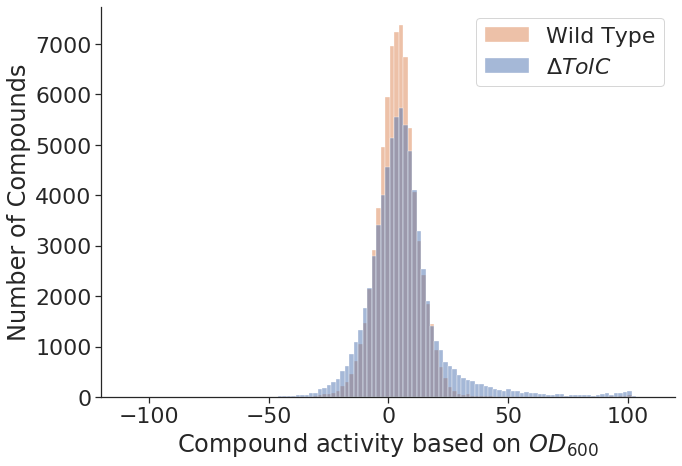

In [218]:

# # e_coli_wild_efflux[['INHIB_AVE_wild', 'INHIB_AVE_efflux']].plot.hist(bins=200, alpha=0.5, figsize=[10,7])


# sns.set(rc={"figure.figsize":(10, 7)}, font_scale=2)
# sns.set_style("ticks")

# sns.histplot(e_coli_wild_efflux[['INHIB_AVE_efflux', 'INHIB_AVE_wild']], alpha=0.5, bins=150)
# sns.despine()

# plt.legend(['Wild Type', '$\Delta TolC$'])

# plt.xlim([-120, 120])

# plt.xlabel('Compound activity based on $OD_{600}$');

# plt.ylabel('Number of Compounds');

# # plt.yticks()
# # plt.xticks()


# plt.tight_layout()
# # plt.savefig('hist_wild_tolc.png')



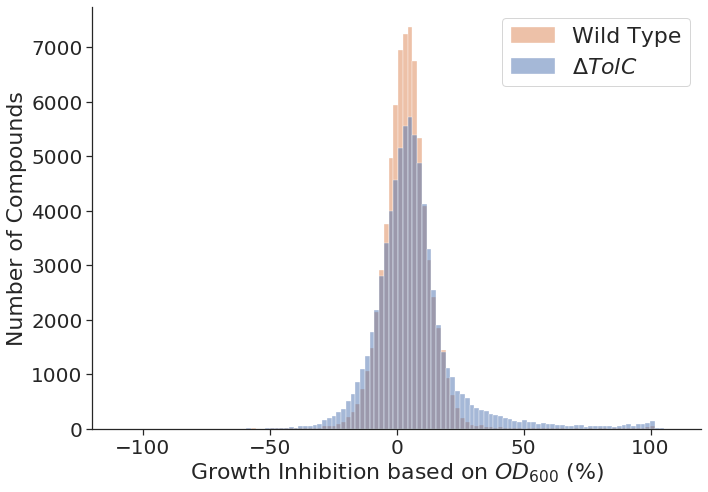

In [50]:
# e_coli_wild_efflux[['INHIB_AVE_wild', 'INHIB_AVE_efflux']].plot.hist(bins=200, alpha=0.5, figsize=[10,7])


sns.set(rc={"figure.figsize":(10, 7)})

sns.set_style("ticks")

sns.histplot(e_coli_wild_efflux[['INHIB_AVE_efflux', 'INHIB_AVE_wild']], alpha=0.5, bins=150)
sns.despine()

plt.legend(['Wild Type', '$\Delta TolC$'],  fontsize=22)

plt.xlim([-120, 120])

plt.xlabel('Growth Inhibition based on $OD_{600}$ (%)', fontsize=22);

plt.ylabel('Number of Compounds',  fontsize=22);

plt.yticks(fontsize=20)
plt.xticks(fontsize=20)


plt.tight_layout()
plt.savefig('figures/hist_wild_tolc.png', dpi=600)


In [4]:
e_coli_wild_efflux.INHIB_AVE_efflux.mean(), e_coli_wild_efflux.INHIB_AVE_wild.mean()

(6.611431868216318, 4.068315397968456)

In [5]:
e_coli_wild_efflux.INHIB_AVE_efflux.std(), e_coli_wild_efflux.INHIB_AVE_wild.std()

(17.071170693888337, 9.732757492784494)

In [7]:
e_coli_wild_efflux.INHIB_AVE_efflux.std()*4 + 6.6, e_coli_wild_efflux.INHIB_AVE_wild.std()*4+4.07

(74.88468277555334, 43.001029971137974)

In [64]:
stats.ttest_rel(e_coli_wild_efflux['INHIB_AVE_wild'], e_coli_wild_efflux['INHIB_AVE_efflux'])

Ttest_relResult(statistic=-44.09489438970853, pvalue=0.0)

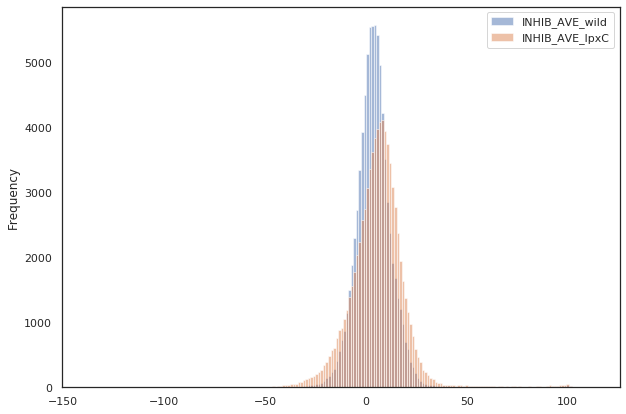

In [68]:
e_coli_wild_perm.plot.hist(bins=200, alpha=0.5, figsize=[10,7])

In [9]:
stats.ttest_rel(e_coli_wild_perm['INHIB_AVE_wild'], e_coli_wild_perm['INHIB_AVE_lpxC'])

Ttest_relResult(statistic=-40.55675268375553, pvalue=0.0)

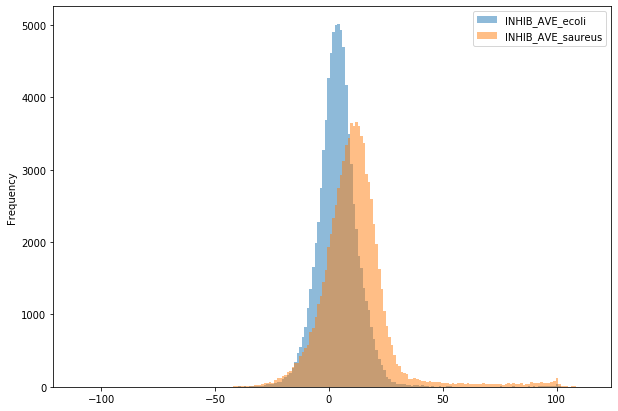

In [23]:
e_coli_s_aureus.plot.hist(bins=200, alpha=0.5, figsize=[10,7])

In [11]:
stats.ttest_rel(e_coli_s_aureus['INHIB_AVE_ecoli'], e_coli_s_aureus['INHIB_AVE_saureus'])

Ttest_relResult(statistic=-137.98270899888263, pvalue=0.0)

The goal is to assign a single value to the compound, two ways to go about that:

we will stick with absolute difference:  find lpxs - wild

### Save the curated datasets:


In [67]:
# e_coli_wild_efflux['SMILES'] = e_coli_wild_efflux['SMILES'].apply(Chem.CanonSmiles)

In [68]:
# e_coli_wild_perm.to_pickle('data_curated/e_coli_wild_perm.pkl')
# e_coli_wild_efflux.to_pickle('data_curated/e_coli_wild_efflux.pkl')
# e_coli_wild.to_pickle('data_curated/e_coli_wild.pkl')
# e_coli_s_aureus.to_pickle('data_curated/e_coli_s_aureus.pkl')

### Dev

In [112]:
# e_coli_wild_perm_only_pos = e_coli_wild_perm[(e_coli_wild_perm['INHIB_AVE_lpxC']>0) & ( e_coli_wild_perm['INHIB_AVE_wild']>0)]
# len(e_coli_wild_perm_only_pos)

44897

/homes/dgurvic/software/miniconda3/envs/jupt_test/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


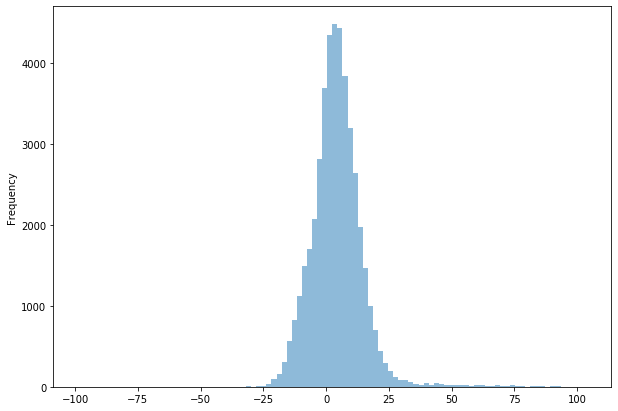

In [113]:
# e_coli_wild_perm_only_pos['perm_diff'] =  e_coli_wild_perm_only_pos['INHIB_AVE_lpxC'] - e_coli_wild_perm_only_pos['INHIB_AVE_wild']
# e_coli_wild_perm_only_pos['perm_diff'].plot.hist(bins=100, alpha=0.5, figsize=[10,7])

Another way to do that is to look at direction and take the right value like so: lpxc > wild



In [109]:
# e_coli_wild_perm_direction = e_coli_wild_perm[(e_coli_wild_perm['INHIB_AVE_lpxC']> e_coli_wild_perm['INHIB_AVE_wild'])]

In [123]:
# e_coli_wild_perm_direction['abs_diff']  = e_coli_wild_perm_direction.INHIB_AVE_lpxC - e_coli_wild_perm_direction.INHIB_AVE_wild

/homes/dgurvic/software/miniconda3/envs/jupt_test/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


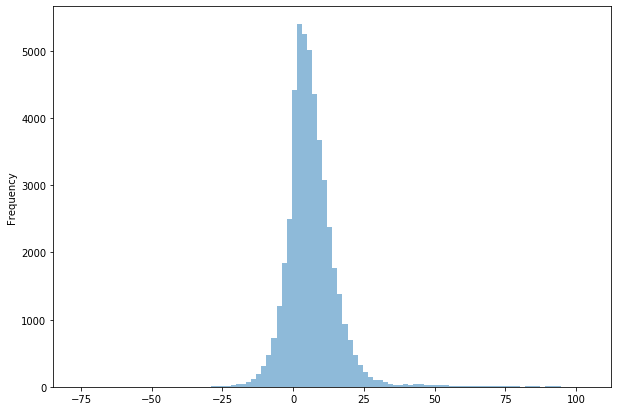

In [119]:
# e_coli_wild_perm_direction['abs_diff'].plot.hist(bins=100, alpha=0.5, figsize=[10,7])

In [125]:
# e_coli_wild_perm_direction[e_coli_wild_perm_direction['abs_diff']>0].head(20)

,SMILES,INHIB_AVE_wild,INHIB_AVE_lpxC,abs_diff
2,B(C1)(CC(C2)CC3CC12)C3.n(cc4Br)cc(c4)Br,12.08,12.83,0.75
3,B(C1)(CC(C2)CC3CC12)C3.n(cccc4Cc5ccccc5)c4,2.94,3.51,0.57
6,B(CC1CC2CC3C1)(C3)C2.N#Cc(cc4)ccn4,7.55,7.56,0.01
9,B(c1ccccc1)(OC(C)CC2P(c3ccccc3)(c4ccccc4)=O)O2,8.95,18.56,9.61
11,B1(c2ccccc2)OC(C)CC(P(c3ccccc3)c4ccccc4)O1,10.17,28.85,18.68
14,BrC(/C(OC1=C2C(C=CC=C3)=C3C=C1)=NBr)(C2C4=C(C=...,-25.63,-10.82,14.81
15,BrC(/C(OC1=C2C(C=CC=C3)=C3C=C1)=NBr)(C2C4=CC(O...,-16.78,5.16,21.94
16,BrC(/C(OC1=C2C(C=CC=C3)=C3C=C1)=NBr)(C2C4=CC([...,-20.79,0.14,20.93
18,BrC(/C(OC1=C2C(C=CC=C3)=C3C=C1)=NBr)(C2C4=CC=C...,-19.75,0.20,19.95
19,BrC(/C(OC1=C2C(C=CC=C3)=C3C=C1)=NBr)(C2C4=CC=C...,-19.01,-16.49,2.52


<!-- ### 5. Find difference in pre and post interested dataset -->


In [12]:
# e_coli_wild_perm['abs_diff']  = e_coli_wild_perm.INHIB_AVE_lpxC - e_coli_wild_perm.INHIB_AVE_wild

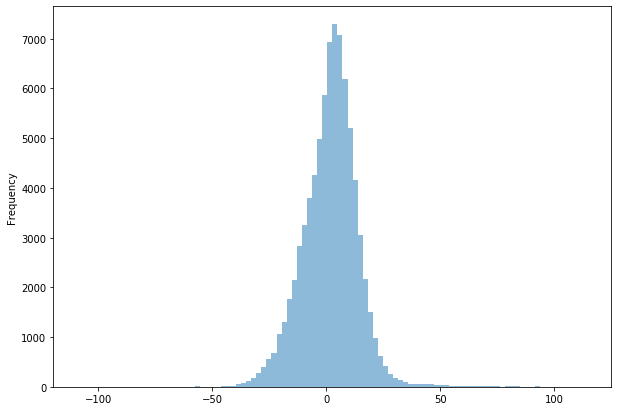

In [13]:
# e_coli_wild_perm['abs_diff'].plot.hist(bins=100, alpha=0.5, figsize=[10,7])

In [12]:
# def calc_feats(df):

#     table=pd.DataFrame()
# #     df=df.dropna() 
    
#     for i,mol in enumerate(df):
# #         Chem.SanitizeMol(mol)
# #         table.loc[i,'SMILES']=Chem.MolToSmiles(mol)
# #         table.loc[i,'Mol']=mol
#         table.loc[i,'MolWt']=Descriptors.MolWt(mol)
#         table.loc[i,'LogP']=Descriptors.MolLogP(mol)
#         table.loc[i,'NumHAcceptors']=Descriptors.NumHAcceptors(mol)
#         table.loc[i,'NumHDonors']=Descriptors.NumHDonors(mol)
#         table.loc[i,'NumHeteroatoms']=Descriptors.NumHeteroatoms(mol)
#         table.loc[i,'NumRotatableBonds']=Descriptors.NumRotatableBonds(mol)
#         table.loc[i,'NumHeavyAtoms']=Descriptors.HeavyAtomCount (mol)
#         table.loc[i,'NumAliphaticCarbocycles']=Descriptors.NumAliphaticCarbocycles(mol)
#         table.loc[i,'NumAliphaticHeterocycles']=Descriptors.NumAliphaticHeterocycles(mol)
#         table.loc[i,'NumAliphaticRings']=Descriptors.NumAliphaticRings(mol)
#         table.loc[i,'NumAromaticCarbocycles']=Descriptors.NumAromaticCarbocycles(mol)
#         table.loc[i,'NumAromaticHeterocycles']=Descriptors.NumAromaticHeterocycles(mol)
#         table.loc[i,'NumAromaticRings']=Descriptors.NumAromaticRings(mol)
#         table.loc[i,'RingCount']=Descriptors.RingCount(mol)
#         table.loc[i,'FractionCSP3']=Descriptors.FractionCSP3(mol)
#         table.loc[i,'TPSA']=Descriptors.TPSA(mol)
    
#     return table



In [20]:
e_coli_wild_efflux_features = calc_feats(e_coli_wild_efflux['Mol'])


In [22]:
e_coli_wild_efflux_features.to_pickle('data_curated/e_coli_wild_efflux_features.pkl')

In [29]:
e_coli_wild_efflux_features['sub_class'] = e_coli_wild_efflux['sub_class']

In [31]:
#pca

table = e_coli_wild_efflux_features

descriptors = table[['MolWt', 'LogP','NumHeteroatoms','RingCount','FractionCSP3', 'TPSA']].values #The non-redundant molecular descriptors chosen for PCA

# descriptors=table.iloc[:,2:]

descriptors_std = StandardScaler().fit_transform(descriptors) #Important to avoid scaling problems between our different descriptors
pca = PCA()
descriptors_2d = pca.fit_transform(descriptors_std)
descriptors_pca= pd.DataFrame(descriptors_2d) # Saving PCA values to a new table
descriptors_pca.index = table.index
descriptors_pca.columns = ['PC{}'.format(i+1) for i in descriptors_pca.columns]
descriptors_pca.head(5) #Displays the PCA table

scale1 = 1.0/(max(descriptors_pca['PC1']) - min(descriptors_pca['PC1'])) 
scale2 = 1.0/(max(descriptors_pca['PC2']) - min(descriptors_pca['PC2']))

# And we add the new values to our PCA table
descriptors_pca['PC1_normalized']=[i*scale1 for i in descriptors_pca['PC1']]
descriptors_pca['PC2_normalized']=[i*scale2 for i in descriptors_pca['PC2']]


descriptors_pca['sub_class'] = e_coli_wild_efflux_features['sub_class']



# plt.rcParams['axes.linewidth'] = 1.5


cmap = sns.diverging_palette(133, 10, as_cmap=True)

fig, ax = plt.subplots(figsize=(13,8))



sns.scatterplot(x='PC1',y='PC2',data=descriptors_pca, alpha=0.7, hue='sub_class',style='sub_class', s=30)#, palette=["C0", "C1", "C2", "k"])


pca_lab= ('PC1 '+str([np.round(pca.explained_variance_ratio_[0]*100, 1)]), 'PC2 '+str([np.round(pca.explained_variance_ratio_[1]*100, 1)]))


plt.xlabel(pca_lab[0],fontsize=16,fontweight='bold')
plt.ylabel(pca_lab[1],fontsize=16,fontweight='bold')

plt.tick_params ('both',width=2,labelsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

handles, labels = ax.get_legend_handles_labels()

#ax.legend(handles=handles[1:], labels=labels[1:])

#plt.legend(loc='lower right',frameon=False,prop={'size': 22},ncol=1)

plt.tight_layout()
plt.show()

print('same but in contours, for ease of read')

cmap = sns.diverging_palette(133, 10, as_cmap=True)

fig, ax = plt.subplots(figsize=(13,8))

sns.kdeplot(x='PC1',y='PC2',data=descriptors_pca, hue='sub_class' , levels=5,)


pca_lab= ('PC1 '+str([np.round(pca.explained_variance_ratio_[0]*100, 1)]), 'PC2 '+str([np.round(pca.explained_variance_ratio_[1]*100, 1)]))


plt.xlabel(pca_lab[0],fontsize=16,fontweight='bold')
plt.ylabel(pca_lab[1],fontsize=16,fontweight='bold')

plt.tick_params ('both',width=2,labelsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

handles, labels = ax.get_legend_handles_labels()

#ax.legend(handles=handles[1:], labels=labels[1:])

#plt.legend(loc='lower right',frameon=False,prop={'size': 22},ncol=1)

plt.tight_layout()
plt.show()

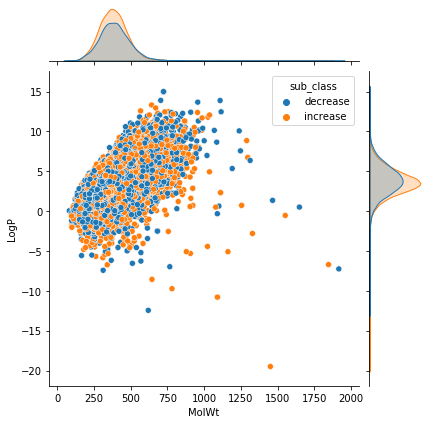

In [42]:
sns.jointplot(data = e_coli_wild_efflux_features,  x = 'MolWt',  y = 'LogP', hue='sub_class',)

In [45]:
e_coli_wild_efflux[['SMILES', 'abs_diff']].to_csv('co_add_wild_efflux.csv', index=False)

In [83]:
#### import the mmpa:



In [48]:
efflux_mmpa_index_len = master_functions.clean_mmpa_pairs_len(efflux_mmpa_index) # filter pairs by len LHS & RHS vs CORE

Initial number of transofrms: 1406980 
Number fo transforms disqualified based on length discrepancy: 526528 
Remaining number of transforms: 880452


In [ ]:
efflux_mmpa_index_len_stat = master_functions.stat_it_2(efflux_mmpa_index_len)

In [50]:
efflux_mmpa_index_len_stat.to_pickle("data_curated/efflux_mmpa_index_len_stat.pkl")

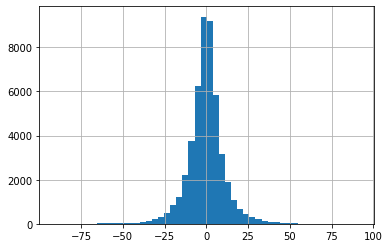

In [17]:
efflux_mmpa_index_len_stat.measurement_delta.hist(bins=50)

In [11]:
efflux_mmpa_neg_pos = master_functions.zero_in(efflux_mmpa_index_len_stat, pos_only=False, cutoff=0.05) #  is this filtering for positive?

Number of unique transforms where p-val < 0.05 is 5197
Split between 2566 positive transforms and 2631 negative transforms


In [14]:
efflux_mmpa_neg_pos = master_functions.split_transition(efflux_mmpa_neg_pos, 'smirks')

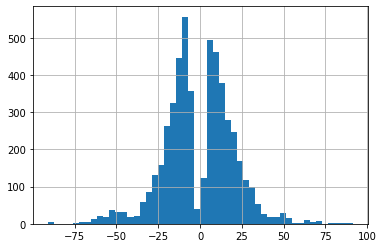

In [18]:
efflux_mmpa_neg_pos.measurement_delta.hist(bins=50)

In [42]:
efflux_mmpa_pos = efflux_mmpa_neg_pos[efflux_mmpa_neg_pos['measurement_delta']>0]

In [47]:
efflux_mmpa_pos[efflux_mmpa_pos['RHS']=='[*:1][H]']

,smirks,dof,t-stat,p-val (t-test),measurement_delta,std,sem,LHS,RHS
157,[*:1]c1nc2ccccc2o1>>[*:1][H],6,3.049545,0.022525,35.437143,30.744866,11.620467,[*:1]c1nc2ccccc2o1,[*:1][H]
476,[*:1]OCc1ccc(Cl)cc1>>[*:1][H],9,3.132617,0.012071,24.295000,24.525031,7.755496,[*:1]OCc1ccc(Cl)cc1,[*:1][H]
542,[*:1]NC(=O)c1cccc(C)c1>>[*:1][H],2,18.650861,0.002862,22.823333,2.119536,1.223715,[*:1]NC(=O)c1cccc(C)c1,[*:1][H]
559,[*:1]NC(=O)c1ccc(Cl)cc1>>[*:1][H],2,5.621207,0.030220,22.516667,6.938014,4.005664,[*:1]NC(=O)c1ccc(Cl)cc1,[*:1][H]
751,[*:1]C(=O)Nc1nnc(C)s1>>[*:1][H],2,5.034021,0.037269,19.633333,6.755223,3.900130,[*:1]C(=O)Nc1nnc(C)s1,[*:1][H]
1091,[*:1]C(=O)Nc1ccc(I)cc1>>[*:1][H],2,20.418814,0.002390,15.080000,1.279179,0.738535,[*:1]C(=O)Nc1ccc(I)cc1,[*:1][H]
1191,[*:1]CCCCCCCC>>[*:1][H],4,8.840509,0.000904,13.916000,3.519834,1.574118,[*:1]CCCCCCCC,[*:1][H]
1315,[*:1]OC(C)C>>[*:1][H],16,2.987736,0.008699,12.592941,17.378383,4.214877,[*:1]OC(C)C,[*:1][H]
1327,[*:1]NC(=O)c1ccccc1>>[*:1][H],13,3.304501,0.005698,12.444286,14.090553,3.765859,[*:1]NC(=O)c1ccccc1,[*:1][H]
1357,[*:1]NC(=O)c1ccc(C)cc1>>[*:1][H],7,2.981994,0.020457,12.155000,11.529043,4.076132,[*:1]NC(=O)c1ccc(C)cc1,[*:1][H]


In [48]:
features_all_pos, l_feats_pos, r_feats_pos = master_functions.calculate_fractions_mk4(efflux_mmpa_pos)

  1%|          | 21/2566 [00:00<00:12, 201.22it/s]

Generating molecular objects from pre-defined substructures
Calcualting LHS+RHS matches


100%|██████████| 2566/2566 [00:12<00:00, 212.06it/s]


In [49]:
to_drop = ['arene', 'heteroarene', 'alkyne', 'benzene ring', 'amine', 'azaarene', 'alkene', 'aryl halide', 'alkyl halide', 'leaving group', 'alkenyl halide']

features_all_dropped = features_all_pos.drop(to_drop, axis = 1)

l_feats_dropped =  l_feats_pos.drop(to_drop, axis = 1)
r_feats_dropped =  r_feats_pos.drop(to_drop, axis = 1)

# fractions_to_drop=['fr_ketone_Topliss', 'fr_Al_OH_noTert', 'fr_Ar_N', 'fr_methoxy', 'fr_C_O', 'fr_phenol_noOrthoHbond' ]
# fractions above are kept as significant but not looked at on the exchange

fr_sig_descriptors = master_functions.find_sig_feats_mk2(l_feats_dropped, r_feats_dropped, 0.01)

Found significant fractions:  18


In [50]:
#fr_sig_descriptors.remove('fr_NH0')
fractions_to_drop=[]

# res_neg= master_functions.results_arr(features_all.drop(columns=['fr_NH0']), fr_sig_descriptors, r_feats, l_feats, fractions_to_drop )

res_neg_neg= master_functions.results_arr(features_all_dropped, fr_sig_descriptors, r_feats_dropped, l_feats_dropped, fractions_to_drop )

aniline has negative correlation 
phenol has positive correlation 
tertiary amine has negative correlation 
enamine has negative correlation 
iminyl has negative correlation 
N-acylcarbamate or urea (mixed imide) has negative correlation 
first_gain
[('secondary carboxamide', 'carboxamide'), 'iminyl', 'aniline']
[71.43, 57.14, 14.29]
percentage_loss 100
carboxamide has negative correlation 
lactam has positive correlation 
oxime ether has positive correlation 
second double loss
['α,β-unsaturated carbonyl', ('1,2-diol', 'carboxylic acid'), 'nitro']
[-15.79, -10.53, -5.26]
alkanol has positive correlation 
second double loss
['ether', ('aryl chloride', 'aryl bromide'), 'carbonyl']
[-17.3, -8.02, -5.91]
α,β-unsaturated carbonyl has negative correlation 
carbonyl has negative correlation 
first_gain
[('aniline', 'ether'), 'aryl bromide', 'alkanol']
[10.08, 6.59, 5.81]
1,2-diol has positive correlation 
ketone has negative correlation 
alkyl fluoride has positive correlation 
aryl bromide 

In [51]:
res_neg_neg

,Main fraction,Correlation,$\overline{\Delta P}$,sem,std,dof,Opposite fraction 1,% of opposite 1,Opposite fraction 2,% of opposite 2,Opposite fraction 3,% of opposite 3
12,"1,2-diol",Positive,41.75,4.41,20.67,22,ether,-22.73,secondary amine,-9.09,aniline,-4.55
13,ketone,Negative,-30.28,4.34,22.14,26,tertiary amine,15.38,"(carboxamide, ether, aryl chloride)",7.69,tertiary carboxamide,7.69
1,phenol,Positive,26.03,1.10,16.68,228,ether,-17.98,aryl chloride,-9.21,aryl bromide,-8.33
9,alkanol,Positive,25.56,1.08,16.56,237,ether,-17.30,"(aryl chloride, aryl bromide)",-8.02,carbonyl,-5.91
3,enamine,Negative,-23.71,2.70,13.77,26,carboxamide,26.92,secondary carboxamide,23.08,hydrazone,3.85
8,oxime ether,Positive,20.57,2.60,11.35,19,"α,β-unsaturated carbonyl",-15.79,"(1,2-diol, carboxylic acid)",-10.53,nitro,-5.26
4,iminyl,Negative,-20.28,1.63,12.38,58,lactam,12.07,sulfide,8.62,primary amine,6.90
10,"α,β-unsaturated carbonyl",Negative,-20.10,1.96,13.03,44,carboxamide,22.73,secondary carboxamide,20.45,oxime ether,6.82
17,sulfide,Positive,19.98,1.22,8.87,53,aniline,-26.42,"(secondary amine, ether)",-24.53,aryl bromide,-18.87
0,aniline,Negative,-19.08,0.68,10.51,236,ether,23.73,aryl chloride,7.20,sulfide,6.78


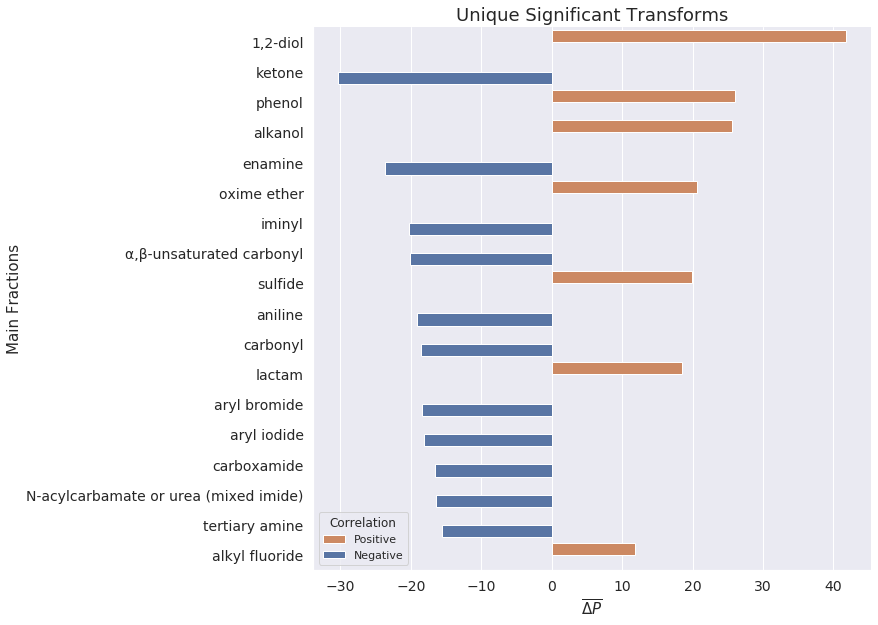

In [52]:
master_functions.plot_feats(res_neg_neg)

# Phase 2: Efflux


### Define substrate,  evader and rest

/homes/dgurvic/software/miniconda3/envs/jupt_test/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/homes/dgurvic/software/miniconda3/envs/jupt_test/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/homes/dgurvic/software/miniconda3/envs/jupt_test/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

In [ ]:

'''
In the similar pairs, have you any compounds that are transformed into efflux evading compounds from non efflux evading ones?

To find that out we must look for Compound_B 

In [96]:
efflux_mmpa_index['comp_b_standard'] = efflux_mmpa_index.compound_structure_B.apply(Chem.CanonSmiles)

In [97]:
evade_effulx['evade_smile_standard'] = evade_effulx.SMILES.apply(Chem.CanonSmiles)

/homes/dgurvic/software/miniconda3/envs/jupt_test/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [5]:
# # Count up the compounds: 

# e_coli_wild_efflux[e_coli_wild_efflux['INHIB_AVE_wild']> e_coli_wild_efflux['INHIB_AVE_efflux']]

,SMILES,INHIB_AVE_wild,INHIB_AVE_efflux,Mol,fps,abs_diff,sub_class
0,B(C1)(CC(C2)CC3CC12)C3.N,12.28,-13.33,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-25.61,decrease
1,B(C1)(CC(C2)CC3CC12)C3.n(cc4)ccc4Cc5ccccc5,3.66,-6.11,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-9.77,decrease
2,B(C1)(CC(C2)CC3CC12)C3.n(cc4Br)cc(c4)Br,12.08,0.47,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-11.61,decrease
3,B(C1)(CC(C2)CC3CC12)C3.n(cccc4Cc5ccccc5)c4,2.94,-4.44,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-7.38,decrease
4,B(C1)(CC2CC1CC3C2)C3.N(C)(C)c(cc4)ccn4,0.96,-23.26,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-24.22,decrease
...,...,...,...,...,...,...,...
73728,s1cc(C=C(C(N([H])C2=O)=O)/C(N2[H])=O)c(ccc3)c1c3,7.84,-9.32,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-17.16,decrease
73729,s1cc(c2c1C(c3ccc(OCc4c(F)cccc4)cc3)CC(=O)N2)c(...,-12.96,-20.41,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-7.45,decrease
73733,s1cccc1CNc(cc2)ccc2Cl,2.59,-4.86,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-7.45,decrease
73734,s1cccc1[As](O)(c(ccc2)s2)=O,16.96,-6.98,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-23.94,decrease


In [12]:
# efflux_positive = e_coli_wild_efflux[e_coli_wild_efflux['INHIB_AVE_efflux'] > 0]

In [14]:
# efflux_positive[(efflux_positive['INHIB_AVE_wild'] < efflux_positive['INHIB_AVE_efflux']) & (efflux_positive['INHIB_AVE_efflux']>50)]

,SMILES,INHIB_AVE_wild,INHIB_AVE_efflux,Mol,fps,abs_diff,sub_class
29,BrC(/C=N\NC1=NC(N2CCOCC2)=NC(N3CCCC3)=N1)=C/C4...,18.02,68.420,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",50.400,increase
145,Brc1cncc(c1)c2cc(NCCCn3ccnc3)nc(n2)c4ccccc4,4.60,80.470,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",75.870,increase
209,C(/C#N)(=C(\CCC(C1)C)/C1)\C(=O)NCc2ccccc2,8.19,67.910,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",59.720,increase
210,C(/C#N)(=C(\O)/Cc1ccccc1)\P(c2ccccc2)(c3ccccc3)=S,2.04,72.280,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",70.240,increase
308,C(/C#N)(\C(N)=S)=N/Nc(cccc1C(F)(F)F)c1,18.36,87.980,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",69.620,increase
...,...,...,...,...,...,...,...
73469,s1c(C)nnc1SCc2c(C)cc(cc2C)C,1.14,75.780,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",74.640,increase
73540,s1c(N)nnc1SCC(=O)Nc(ccc(c2Cl)Cl)c2,10.29,57.110,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",46.820,increase
73621,s1c(\N=C\c2cccc(OC)c2O)nnc1c3cccc(C)c3,12.47,52.410,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",39.940,increase
73672,s1c(c2ccc(cc2)C)nnc1NC(=O)C(Cl)(Cl)Cl,24.02,50.060,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",26.040,increase


In [ ]:
# efflux_positive[(efflux_positive['INHIB_AVE_wild'] < efflux_positive['INHIB_AVE_efflux']) & (efflux_positive['INHIB_AVE_efflux']>50) &  (efflux_positive['INHIB_AVE_wild']>50)]

## Define 'active compound'


In [ ]:
# 4 log_2 folds away
# below 3 std away from average

In [9]:
# z-score:

e_coli_wild_efflux['wild_stds'] = stats.zscore(e_coli_wild_efflux.INHIB_AVE_wild)
e_coli_wild_efflux['tolc_stds'] = stats.zscore(e_coli_wild_efflux.INHIB_AVE_efflux)

In [10]:
threshold = 4

def label_it(row):
    if row['wild_stds'] >=threshold:
        return 'active'
    if row['wild_stds'] <threshold:
        return 'inactive'
    
    
e_coli_wild_efflux['wild_class'] = e_coli_wild_efflux.apply(label_it, axis=1)

In [11]:
def label_it(row):
    if row['tolc_stds'] >=threshold:
        return 'active'
    if row['tolc_stds'] <threshold:
        return 'inactive'
    
    
e_coli_wild_efflux['tolc_class'] = e_coli_wild_efflux.apply(label_it, axis=1)

In [12]:
def label_substrate(row):
    if row['tolc_class'] == 'active' and row['wild_class'] == 'inactive':
        return 'Efflux Substrate'
    if row['tolc_class'] == 'active' and row['wild_class'] == 'active':
        return 'Efflux Evader'
    if row['tolc_class'] == 'inactive' and row['wild_class'] == 'inactive':
        return 'Inactive'
    if row['tolc_class'] == 'inactive' and row['wild_class'] == 'active':
        return 'WT-only Active'

In [13]:
e_coli_wild_efflux['Class'] = e_coli_wild_efflux.apply(label_substrate, axis=1)

In [14]:
e_coli_wild_efflux.Class.value_counts()

Inactive            72724
Efflux Substrate      760
Efflux Evader         200
WT-only Active         53
Name: Class, dtype: int64

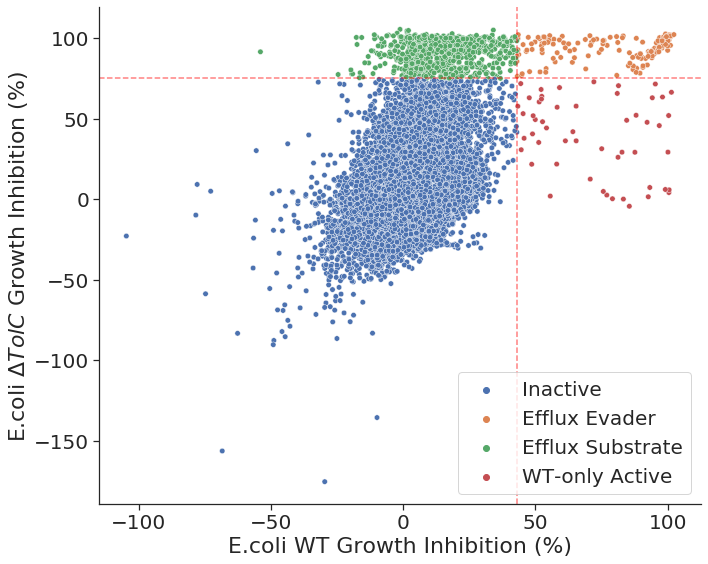

In [51]:
# e_coli_wild_efflux[['INHIB_AVE_wild', 'INHIB_AVE_efflux']].plot.hist(bins=200, alpha=0.5, figsize=[10,7])

sns.set(rc={"figure.figsize":(10, 8)})
sns.set_style("ticks")

sns.scatterplot(data = e_coli_wild_efflux, x='INHIB_AVE_wild', y='INHIB_AVE_efflux', hue='Class', s=30)

sns.despine()

plt.legend(fontsize=20)

# plt.xlim([-120, 120])

plt.xlabel('E.coli WT Growth Inhibition (%)', fontsize=22);

plt.ylabel('E.coli $\Delta TolC$ Growth Inhibition (%)',  fontsize=22);

plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

plt.axvline(x=43.02,  color='red', linestyle='--', alpha=0.5)
plt.axhline(y=74.98,  color='red', linestyle='--', alpha=0.5)

plt.tight_layout()

# plt.savefig('figures/wild_tolc_class_scatter.png', dpi=600)

In [ ]:
e_coli_wild_efflux[e_coli_wild_efflux['wild_stds']>4].sort_values(by='wild_stds')

,SMILES,INHIB_AVE_wild,INHIB_AVE_efflux,Mol,fps,abs_diff,sub_class,wild_stds,tolc_stds,wild_class,tolc_class,Class
36040,CCCCCCCCCCCNC(=O)c1ccc(NC(=O)c2cccc(C)c2)cc1,43.02,85.55,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",42.53,increase,4.002149,4.624118,active,active,Evader
25810,Br.O=C(CN(C1=NCCCCC1)c1ccc(Br)cc1)c1ccc(C2CCCC...,43.06,88.91,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",45.85,increase,4.006259,4.820942,active,active,Evader
29584,CC1(c2cccc([N+](=O)[O-])c2)Nc2ccccc2C(=O)N1/N=...,43.13,76.34,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",33.21,increase,4.013451,4.084608,active,active,Evader
18822,O=C(NN=C1CSc2sc(=O)sc2SC1)c1ccccc1O,43.32,57.73,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",14.41,increase,4.032973,2.994459,active,inactive,Unclassified
38895,Oc1c(I)cc(I)c2cccnc12,43.38,99.77,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",56.39,increase,4.039138,5.457107,active,active,Evader
...,...,...,...,...,...,...,...,...,...,...,...,...
28235,Br.CCCCCCCCCCn1ccc(=N)cc1,101.08,95.52,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-5.56,decrease,9.967611,5.208147,active,active,Evader
21558,CCN1CCN(c2cc3c(cc2F)c(=O)c(C(=O)O)cn3C2CC2)CC1,101.15,101.88,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.73,increase,9.974803,5.580708,active,active,Evader
67523,O=[N+]([O-])c1ccc(C=[N+]([O-])CCO)o1,101.33,101.32,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",-0.01,decrease,9.993298,5.547904,active,active,Evader
21276,CSC1SCC2C(=O)N(C)C(C(C)C)C(=O)OCC(NC(=O)c3cnc4...,101.44,66.39,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-35.05,decrease,10.004600,3.501750,active,inactive,Unclassified


In [ ]:
e_coli_wild_efflux[e_coli_wild_efflux['wild_stds']>=4].sort_values(by='wild_stds')

,SMILES,INHIB_AVE_wild,INHIB_AVE_efflux,Mol,fps,abs_diff,sub_class,wild_stds,tolc_stds,wild_class,tolc_class,evader_class,Class
36040,CCCCCCCCCCCNC(=O)c1ccc(NC(=O)c2cccc(C)c2)cc1,43.02,85.55,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",42.53,increase,4.002149,4.624118,active,active,Evader,Evader
25810,Br.O=C(CN(C1=NCCCCC1)c1ccc(Br)cc1)c1ccc(C2CCCC...,43.06,88.91,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",45.85,increase,4.006259,4.820942,active,active,Evader,Evader
29584,CC1(c2cccc([N+](=O)[O-])c2)Nc2ccccc2C(=O)N1/N=...,43.13,76.34,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",33.21,increase,4.013451,4.084608,active,active,Evader,Evader
18822,O=C(NN=C1CSc2sc(=O)sc2SC1)c1ccccc1O,43.32,57.73,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",14.41,increase,4.032973,2.994459,active,inactive,Unclassified,Unclassified
38895,Oc1c(I)cc(I)c2cccnc12,43.38,99.77,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",56.39,increase,4.039138,5.457107,active,active,Evader,Evader
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28235,Br.CCCCCCCCCCn1ccc(=N)cc1,101.08,95.52,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-5.56,decrease,9.967611,5.208147,active,active,Evader,Evader
21558,CCN1CCN(c2cc3c(cc2F)c(=O)c(C(=O)O)cn3C2CC2)CC1,101.15,101.88,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.73,increase,9.974803,5.580708,active,active,Evader,Evader
67523,O=[N+]([O-])c1ccc(C=[N+]([O-])CCO)o1,101.33,101.32,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",-0.01,decrease,9.993298,5.547904,active,active,Evader,Evader
21276,CSC1SCC2C(=O)N(C)C(C(C)C)C(=O)OCC(NC(=O)c3cnc4...,101.44,66.39,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-35.05,decrease,10.004600,3.501750,active,inactive,Unclassified,Unclassified


In [31]:
# 4x log_2 folds

# e_coli_wild_efflux['log_2_fold_change_wild'] = np.log2(e_coli_wild_efflux.INHIB_AVE_wild / e_coli_wild_efflux.INHIB_AVE_wild.mean())
# e_coli_wild_efflux['log_2_fold_change_efflux'] = np.log2(e_coli_wild_efflux.INHIB_AVE_efflux / e_coli_wild_efflux.INHIB_AVE_efflux.mean())


/homes/dgurvic/software/miniconda3/envs/jupt_test/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/homes/dgurvic/software/miniconda3/envs/jupt_test/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Define substrate, evader, rest, wt-only

In [52]:
e_coli_wild_efflux

,SMILES,INHIB_AVE_wild,INHIB_AVE_efflux,Mol,fps,abs_diff,sub_class,wild_stds,tolc_stds,wild_class,tolc_class,Class
0,C1B2CC3CC1CC(C2)C3.N,12.28,-13.330,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-25.610,decrease,0.843722,-1.168143,inactive,inactive,Inactive
1,C1B2CC3CC1CC(C2)C3.c1ccc(Cc2ccncc2)cc1,3.66,-6.110,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-9.770,decrease,-0.041953,-0.745205,inactive,inactive,Inactive
2,Brc1cncc(Br)c1.C1B2CC3CC1CC(C2)C3,12.08,0.470,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-11.610,decrease,0.823173,-0.359757,inactive,inactive,Inactive
3,C1B2CC3CC1CC(C2)C3.c1ccc(Cc2cccnc2)cc1,2.94,-4.440,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-7.380,decrease,-0.115930,-0.647378,inactive,inactive,Inactive
4,C1B2CC3CC1CC(C2)C3.CN(C)c1ccncc1,0.96,-23.260,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-24.220,decrease,-0.319369,-1.749829,inactive,inactive,Inactive
...,...,...,...,...,...,...,...,...,...,...,...,...
73732,Cl.c1csc(CNCc2cccs2)c1,-2.77,17.290,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",20.060,increase,-0.702613,0.625537,inactive,inactive,Inactive
73733,Clc1ccc(NCc2cccs2)cc1,2.59,-4.860,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-7.450,decrease,-0.151892,-0.671981,inactive,inactive,Inactive
73734,O=[As](O)(c1cccs1)c1cccs1,16.96,-6.980,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-23.940,decrease,1.324575,-0.796168,inactive,inactive,Inactive
73735,COc1cc([C@@H]2c3cc4c(cc3[C@@H](OC3OC5CO[C@@H](...,7.98,101.765,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",93.785,increase,0.401912,5.573971,inactive,active,Efflux Substrate


In [22]:
efflux_substrate = e_coli_wild_efflux[e_coli_wild_efflux['Class']=='Efflux Substrate']

efflux_evader = e_coli_wild_efflux[e_coli_wild_efflux['Class']=='Efflux Evader']

wt_only = e_coli_wild_efflux[e_coli_wild_efflux['Class']=='WT-only Active']

inactive = e_coli_wild_efflux[e_coli_wild_efflux['Class']=='Inactive']

sub_and_evade = efflux_evader.append(efflux_substrate).reset_index(drop=True)



In [ ]:
# efflux_substrate = e_coli_wild_efflux[(e_coli_wild_efflux['INHIB_AVE_efflux']>65)&(e_coli_wild_efflux['INHIB_AVE_wild']<65)]

# efflux_evader = e_coli_wild_efflux[(e_coli_wild_efflux['INHIB_AVE_wild']>65)&(e_coli_wild_efflux['INHIB_AVE_efflux']>65)]

# wt_only =  e_coli_wild_efflux[(e_coli_wild_efflux['INHIB_AVE_wild']>65)&(e_coli_wild_efflux['INHIB_AVE_efflux']>65)]

# rest_of_ecoli_efflux = e_coli_wild_efflux[~e_coli_wild_efflux['SMILES'].isin(sub_and_evade['SMILES'])]

# efflux_substrate['label']='efflux_substrate'
# efflux_evader['label']='efflux_evader'
# rest_of_ecoli_efflux['label'] = 'rest_of_ecoli_data'

# sub_and_evade = efflux_evader.append(efflux_substrate).reset_index(drop=True)

# sub_and_evade.to_pickle('data_curated/sub_and_evade.pkl')
# rest_of_ecoli_efflux.to_pickle('data_curated/rest_of_ecoli_efflux.pkl')

# efflux_mmpa_index.to_pickle('data_curated/efflux_mmpa_index.pkl')

## Plot histogram wild vs tolC

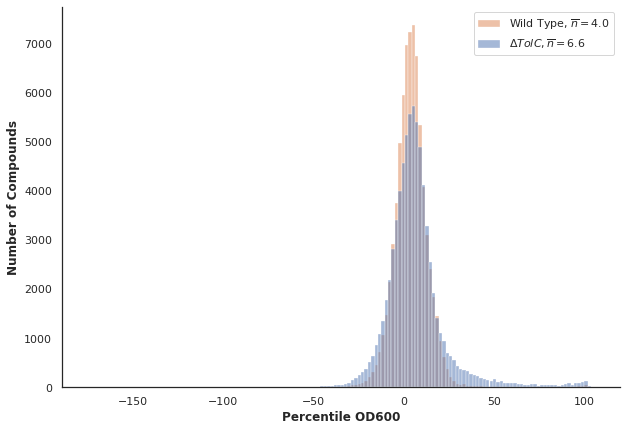

In [51]:
# e_coli_wild_efflux[['INHIB_AVE_wild', 'INHIB_AVE_efflux']].plot.hist(bins=200, alpha=0.5, figsize=[10,7])


sns.set(rc={"figure.figsize":(10, 7)})
sns.set_style("white")

sns.histplot(e_coli_wild_efflux[['INHIB_AVE_efflux', 'INHIB_AVE_wild']], alpha=0.5, bins=150)
sns.despine()

plt.legend(['Wild Type, $\overline{n} = 4.0$', '$\Delta TolC, \overline{n} = 6.6 $'])


plt.xlabel('Percentile OD600', weight='bold');
plt.ylabel('Number of Compounds', weight='bold');

## scatterplot of tolC vs wild

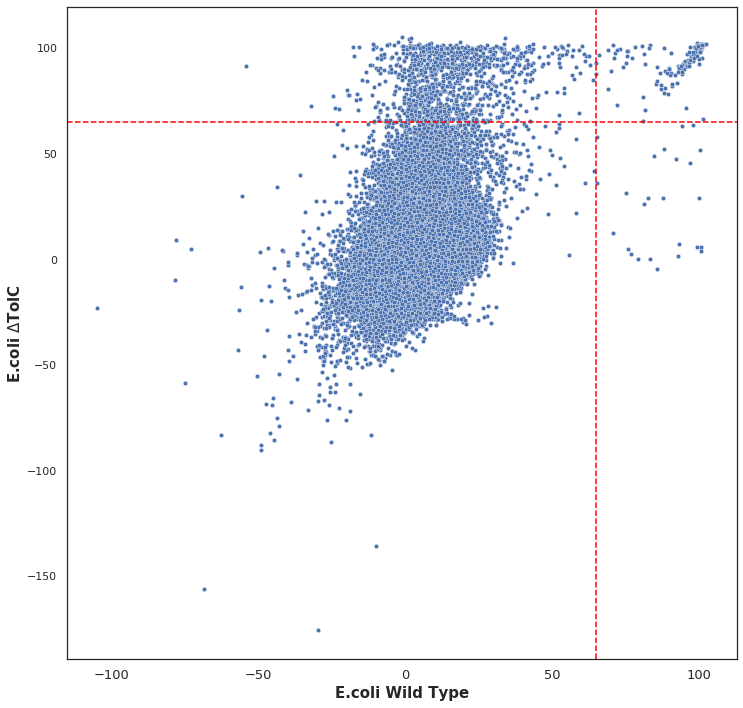

In [113]:
fig, ax = plt.subplots(figsize=(12,12))
sns.set_style("white")
sns.scatterplot(x='INHIB_AVE_wild', y='INHIB_AVE_efflux', data=e_coli_wild_efflux, s=20)

plt.axvline(x=65,  color='red', linestyle='--')
plt.axhline(y=65,  color='red', linestyle='--')

plt.xlabel('E.coli Wild Type', fontsize=15, weight='bold')
plt.ylabel('E.coli $\Delta$TolC', fontsize=15, weight='bold')

plt.xticks(fontsize=13);
plt.xticks(fontsize=13);

plt.savefig('wild_vs_efflux.png', dpi=1000)

## TSNE of evader vs substrate

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 960 samples in 0.056s...
[t-SNE] Computed neighbors for 960 samples in 1.390s...
[t-SNE] Computed conditional probabilities for sample 960 / 960
[t-SNE] Mean sigma: 1.137058
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.697342
[t-SNE] KL divergence after 1000 iterations: 0.650455


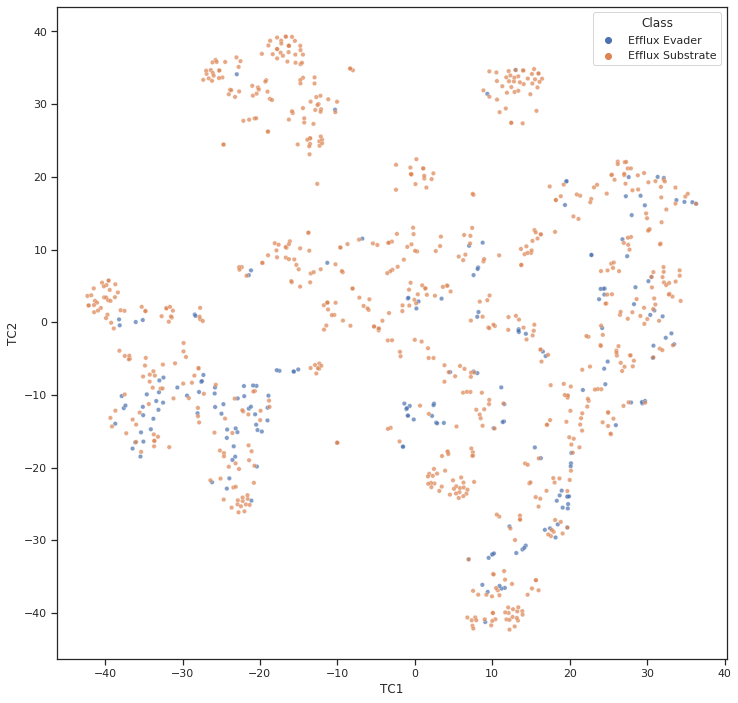

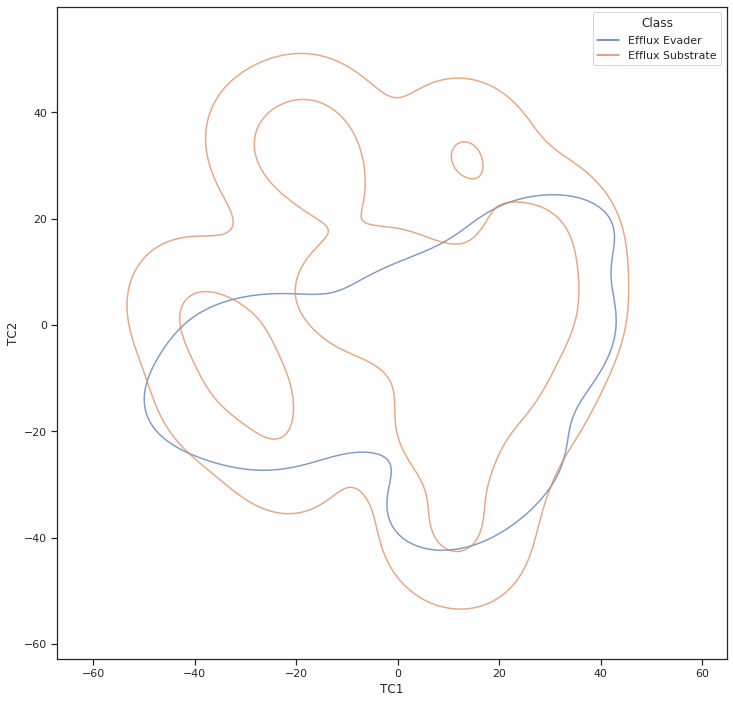

In [58]:
sub_and_evade_tsne = master_functions.tsne_no_plot(sub_and_evade['fps'], perp=30)

fig, ax = plt.subplots(figsize=(12,12))
sns.scatterplot(x='TC1',y='TC2',data=sub_and_evade_tsne, s=20 ,alpha=0.7, hue=sub_and_evade['Class']) 

fig, ax = plt.subplots(figsize=(12,12))

sns.kdeplot(x='TC1',y='TC2',data=sub_and_evade_tsne,alpha=0.7, hue=sub_and_evade['Class'], levels = 3)

## TSNE of evades + substrates + rest of compounds(sample)

In [53]:
sub_evade_rest_sample = sub_and_evade.append(inactive.sample(1000)).reset_index(drop=True)

sub_evade_rest_sample_tsne = master_functions.tsne_no_plot(sub_evade_rest_sample['fps'], perp=50)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1960 samples in 0.229s...
[t-SNE] Computed neighbors for 1960 samples in 13.017s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1960
[t-SNE] Computed conditional probabilities for sample 1960 / 1960
[t-SNE] Mean sigma: 1.530414
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.860733
[t-SNE] KL divergence after 1000 iterations: 0.976216


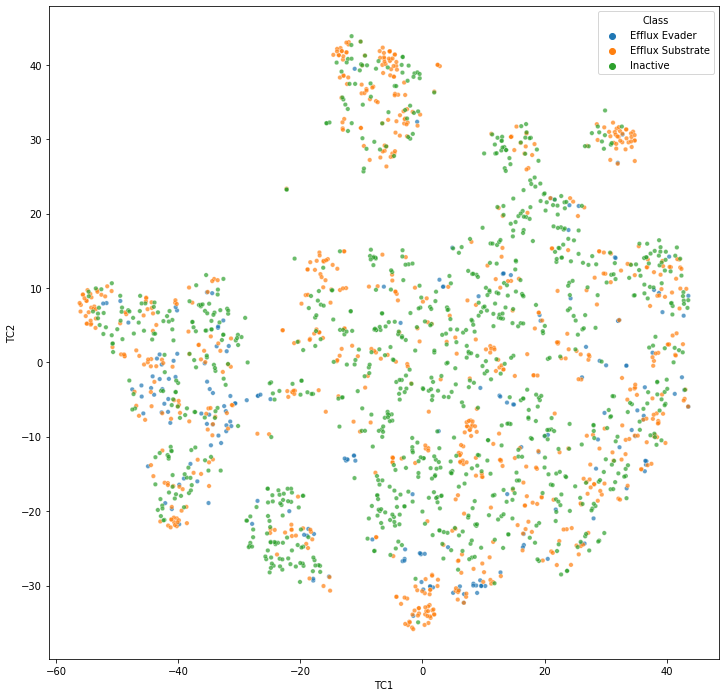

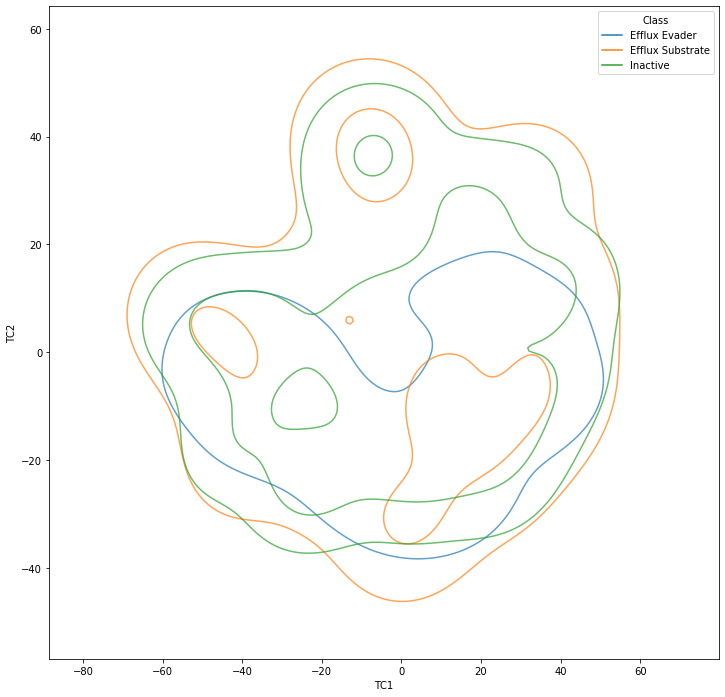

In [55]:
fig, ax = plt.subplots(figsize=(12,12))
sns.scatterplot(x='TC1',y='TC2',data=sub_evade_rest_sample_tsne, s=20 ,alpha=0.7, hue=sub_evade_rest_sample['Class']) 

fig, ax = plt.subplots(figsize=(12,12))

sns.kdeplot(x='TC1',y='TC2',data=sub_evade_rest_sample_tsne,alpha=0.7, hue=sub_evade_rest_sample['Class'], levels = 3)

## PCA of evader vs substrate

In [31]:
sub_and_evade_features = master_functions.calc_feats(sub_and_evade['Mol'])
sub_and_evade_features['Class'] = sub_and_evade['Class']

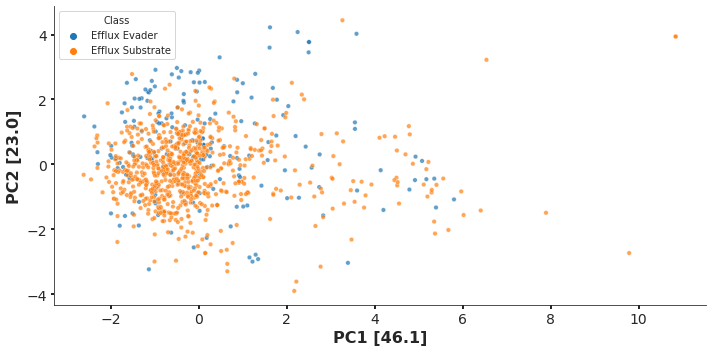

same but in contours, for ease of read


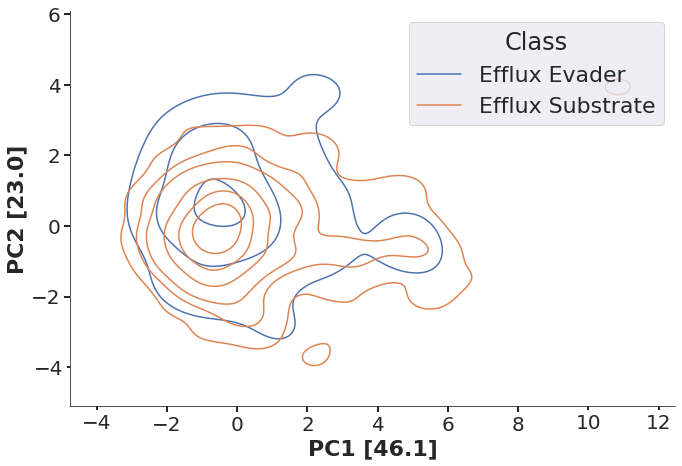

In [84]:
#pca

table = sub_and_evade_features

descriptors = table[['MolWt', 'LogP','NumHeteroatoms','RingCount','FractionCSP3', 'TPSA']].values #The non-redundant molecular descriptors chosen for PCA

# descriptors=table.iloc[:,:-1]

descriptors_std = StandardScaler().fit_transform(descriptors) #Important to avoid scaling problems between our different descriptors
pca = PCA()
descriptors_2d = pca.fit_transform(descriptors_std)
descriptors_pca= pd.DataFrame(descriptors_2d) # Saving PCA values to a new table
descriptors_pca.index = table.index
descriptors_pca.columns = ['PC{}'.format(i+1) for i in descriptors_pca.columns]
descriptors_pca.head(5) #Displays the PCA table

scale1 = 1.0/(max(descriptors_pca['PC1']) - min(descriptors_pca['PC1'])) 
scale2 = 1.0/(max(descriptors_pca['PC2']) - min(descriptors_pca['PC2']))

# And we add the new values to our PCA table
descriptors_pca['PC1_normalized']=[i*scale1 for i in descriptors_pca['PC1']]
descriptors_pca['PC2_normalized']=[i*scale2 for i in descriptors_pca['PC2']]


descriptors_pca['Class'] = sub_and_evade_features['Class']



# plt.rcParams['axes.linewidth'] = 1.5


cmap = sns.diverging_palette(133, 10, as_cmap=True)

fig, ax = plt.subplots(figsize=(10,5))

sns.scatterplot(x='PC1',y='PC2',data=descriptors_pca, alpha=0.7, hue='Class', s=20)#, palette=["C0", "C1", "C2", "k"])


pca_lab = ('PC1 '+str([np.round(pca.explained_variance_ratio_[0]*100, 1)]), 'PC2 '+str([np.round(pca.explained_variance_ratio_[1]*100, 1)]))


plt.xlabel(pca_lab[0],fontsize=16,fontweight='bold')
plt.ylabel(pca_lab[1],fontsize=16,fontweight='bold')

plt.tick_params ('both',width=2,labelsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

handles, labels = ax.get_legend_handles_labels()

#ax.legend(handles=handles[1:], labels=labels[1:])

#plt.legend(loc='lower right',frameon=False,prop={'size': 22},ncol=1)

plt.tight_layout()

plt.savefig('figures/pca_evade_substrate.png', dpi=600)

plt.show()

print('same but in contours, for ease of read')

cmap = sns.diverging_palette(133, 10, as_cmap=True)


############ kdeplot


fig, ax = plt.subplots(figsize=(10,7))

sns.set_style("ticks")

sns.set(font_scale=2)

sns.kdeplot(x='PC1',y='PC2',data=descriptors_pca, hue='Class' , levels=7,)


pca_lab= ('PC1 '+str([np.round(pca.explained_variance_ratio_[0]*100, 1)]), 'PC2 '+str([np.round(pca.explained_variance_ratio_[1]*100, 1)]))


plt.xlabel(pca_lab[0],fontweight='bold',fontsize=22)
plt.ylabel(pca_lab[1],fontweight='bold', fontsize=22)

plt.tick_params ('both',width=2,labelsize=20)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

handles, labels = ax.get_legend_handles_labels()

#ax.legend(handles=handles[1:], labels=labels[1:])

#plt.legend(loc='lower right',frameon=False,prop={'size': 22},ncol=1)

# plt.legend()

plt.tight_layout()

plt.savefig('figures/pca_evade_substrate_contour.png', dpi=600)

## PCA of evader _ substrates_ rest of compounds (sample)

In [70]:
rest_vs_evade_sub = sub_and_evade.append(inactive.sample(5000), sort=False).reset_index(drop=True)

In [71]:
rest_vs_evade_sub_features = master_functions.calc_feats(rest_vs_evade_sub['Mol'])
rest_vs_evade_sub_features['Class'] = rest_vs_evade_sub['Class']

In [72]:
rest_vs_evade_sub_features.Class.value_counts()

Inactive            5000
Efflux Substrate     760
Efflux Evader        200
Name: Class, dtype: int64

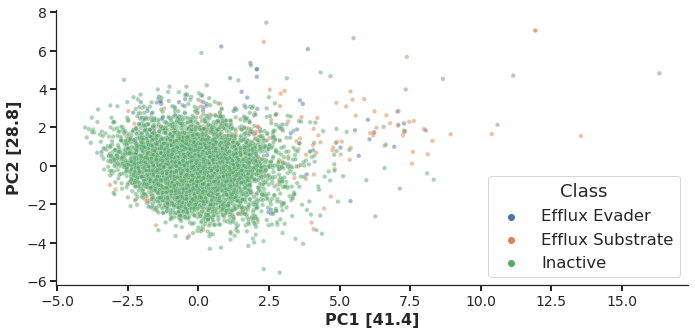

same but in contours, for ease of read


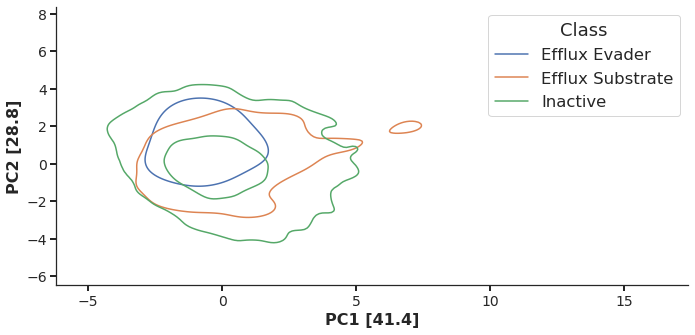

In [97]:
#pca

table = rest_vs_evade_sub_features

descriptors = table[['MolWt', 'LogP','NumHeteroatoms','RingCount','FractionCSP3', 'TPSA']].values #The non-redundant molecular descriptors chosen for PCA

# descriptors=table.iloc[:,2:]

descriptors_std = StandardScaler().fit_transform(descriptors) #Important to avoid scaling problems between our different descriptors
pca = PCA()
descriptors_2d = pca.fit_transform(descriptors_std)
descriptors_pca= pd.DataFrame(descriptors_2d) # Saving PCA values to a new table
descriptors_pca.index = table.index
descriptors_pca.columns = ['PC{}'.format(i+1) for i in descriptors_pca.columns]
descriptors_pca.head(5) #Displays the PCA table

scale1 = 1.0/(max(descriptors_pca['PC1']) - min(descriptors_pca['PC1'])) 
scale2 = 1.0/(max(descriptors_pca['PC2']) - min(descriptors_pca['PC2']))

# And we add the new values to our PCA table
descriptors_pca['PC1_normalized']=[i*scale1 for i in descriptors_pca['PC1']]
descriptors_pca['PC2_normalized']=[i*scale2 for i in descriptors_pca['PC2']]


descriptors_pca['Class'] = rest_vs_evade_sub['Class']



# plt.rcParams['axes.linewidth'] = 1.5


cmap = sns.diverging_palette(133, 10, as_cmap=True)

fig, ax = plt.subplots(figsize=(10,5))

sns.set_style("ticks")

sns.scatterplot(x='PC1',y='PC2',data=descriptors_pca, alpha=0.5, hue='Class', s=20)#, palette=["C0", "C1", "C2", "k"])


pca_lab= ('PC1 '+str([np.round(pca.explained_variance_ratio_[0]*100, 1)]), 'PC2 '+str([np.round(pca.explained_variance_ratio_[1]*100, 1)]))


plt.xlabel(pca_lab[0],fontsize=16,fontweight='bold')
plt.ylabel(pca_lab[1],fontsize=16,fontweight='bold')

plt.tick_params ('both',width=2,labelsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

handles, labels = ax.get_legend_handles_labels()

#ax.legend(handles=handles[1:], labels=labels[1:])

#plt.legend(loc='lower right',frameon=False,prop={'size': 22},ncol=1)

plt.tight_layout()
plt.show()

print('same but in contours, for ease of read')

cmap = sns.diverging_palette(133, 10, as_cmap=True)


############# kdeplot



fig, ax = plt.subplots(figsize=(10,5))


sns.set(font_scale=1.5)

sns.set_style("ticks")


sns.kdeplot(x='PC1',y='PC2',data=descriptors_pca, hue='Class' , levels=3,)


pca_lab= ('PC1 '+str([np.round(pca.explained_variance_ratio_[0]*100, 1)]), 'PC2 '+str([np.round(pca.explained_variance_ratio_[1]*100, 1)]))


plt.xlabel(pca_lab[0],fontsize=16,fontweight='bold')
plt.ylabel(pca_lab[1],fontsize=16,fontweight='bold')

plt.tick_params ('both',width=2,labelsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

handles, labels = ax.get_legend_handles_labels()

#ax.legend(handles=handles[1:], labels=labels[1:])

#plt.legend(loc='lower right',frameon=False,prop={'size': 22},ncol=1)

plt.tight_layout()
# plt.show()

plt.savefig('figures/pca_all_contour.png', dpi=600)

## Mol vs LogP

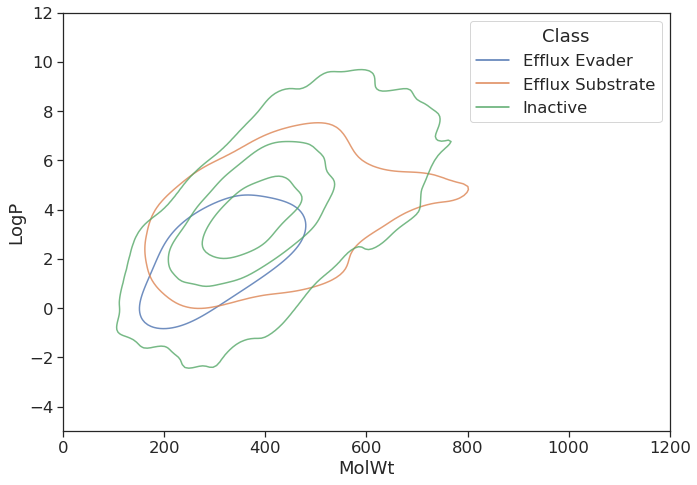

In [96]:

fig, ax = plt.subplots(figsize=(10,7))

sns.kdeplot(data = rest_vs_evade_sub_features, x='MolWt', y='LogP', hue='Class', hue_order=[ 'Efflux Evader', 'Efflux Substrate', 'Inactive'], alpha=0.8, levels=4 )
plt.tight_layout()

plt.xlim([0, 1200])
plt.ylim([-5, 12])

plt.savefig('figures/mol_logp_kde.png', dpi=600)

## Make smiles canonical so we can compare them:


In [18]:
# make smiles canonical so we can compare them:

efflux_mmpa_index['compound_structure_B'] = efflux_mmpa_index.compound_structure_B.apply(Chem.CanonSmiles)
efflux_mmpa_index['compound_structure_A'] = efflux_mmpa_index.compound_structure_A.apply(Chem.CanonSmiles)

efflux_evader['SMILES'] = efflux_evader.SMILES.apply(Chem.CanonSmiles)
efflux_substrate['SMILES'] = efflux_substrate.SMILES.apply(Chem.CanonSmiles)

efflux_evader = efflux_evader.drop_duplicates(subset=['SMILES'])

efflux_substrate = efflux_substrate.drop_duplicates(subset=['SMILES'])

rest_of_ecoli_efflux['SMILES'] = rest_of_ecoli_efflux.SMILES.apply(Chem.CanonSmiles)

e_coli_wild_efflux['SMILES'] = e_coli_wild_efflux['SMILES'].apply(Chem.CanonSmiles)

/homes/dgurvic/software/miniconda3/envs/jupt_test/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/homes/dgurvic/software/miniconda3/envs/jupt_test/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


# Transforms leading to efflux evaders

In [94]:
# find efflux evaders 

evader_transforms = efflux_mmpa_index[(efflux_mmpa_index['compound_structure_B'].isin(efflux_evader.SMILES)) & (efflux_mmpa_index['compound_structure_A'].isin(rest_of_ecoli_efflux.SMILES))]

evader_transforms = master_functions.clean_mmpa_pairs_len(evader_transforms)

evader_transforms.to_pickle('data_curated/evader_transforms.pkl')

Initial number of transofrms: 2880 
Number fo transforms disqualified based on length discrepancy: 2268 
Remaining number of transforms: 612


In [95]:
len(evader_transforms.compound_structure_A.unique())

418

In [96]:
len(evader_transforms.compound_structure_B.unique())

78

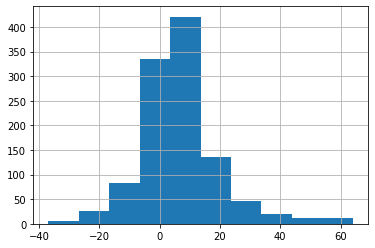

In [135]:
# e_coli_wild_efflux[e_coli_wild_efflux['SMILES'].isin(evader_transforms.compound_structure_A)].INHIB_AVE_efflux.hist()

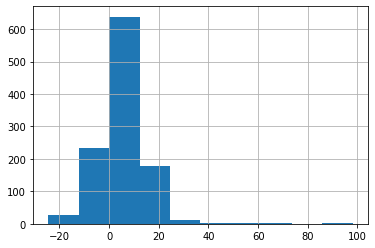

In [136]:
# e_coli_wild_efflux[e_coli_wild_efflux['SMILES'].isin(evader_transforms.compound_structure_A)].INHIB_AVE_wild.hist()

In [137]:
# e_coli_wild_efflux[e_coli_wild_efflux['SMILES'].isin(evader_transforms.compound_structure_A)]

,SMILES,INHIB_AVE_wild,INHIB_AVE_efflux,Mol,fps,abs_diff,sub_class
32,COc1cc(Br)c(C=O)cc1OC,5.00,-2.93,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-7.93,decrease
42,N#Cc1cc(Br)cc(Br)c1N,14.62,3.75,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-10.87,decrease
64,Cc1ccc2nc(-c3ccc(/N=C/c4cc(Br)ccc4O)cc3)sc2c1,11.35,-11.72,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-23.07,decrease
129,Cc1nc(Br)c(Br)c(C)c1Br,7.33,2.59,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-4.74,decrease
132,Nc1ccc(Br)cc1Br,2.13,0.26,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-1.87,decrease
...,...,...,...,...,...,...,...
73495,Nc1nnc(CCc2ccccc2)s1,-1.89,-7.02,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-5.13,decrease
73509,Nc1nnc(Cc2ccccc2)s1,-5.26,-5.67,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-0.41,decrease
73526,NNC(=O)Cc1nnc(N)s1,7.35,3.77,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-3.58,decrease
73552,CC(=O)CSc1nnc(N)s1,-0.10,-3.07,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-2.97,decrease


# Transforms leading to efflux substrates

In [97]:
substrate_transforms = efflux_mmpa_index[(efflux_mmpa_index['compound_structure_B'].isin(efflux_substrate.SMILES)) & (efflux_mmpa_index['compound_structure_A'].isin(rest_of_ecoli_efflux.SMILES)) ]


substrate_transforms = master_functions.clean_mmpa_pairs_len(substrate_transforms)

substrate_transforms.to_pickle('data_curated/substrate_transforms.pkl')

Initial number of transofrms: 10619 
Number fo transforms disqualified based on length discrepancy: 2694 
Remaining number of transforms: 7925


In [98]:
len(substrate_transforms.compound_structure_A.unique())

2799

In [99]:
len(substrate_transforms.compound_structure_B.unique())

488

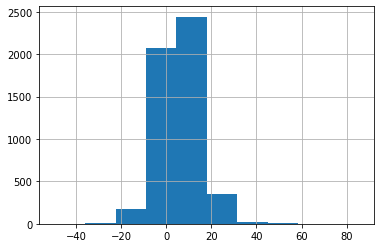

In [141]:
# e_coli_wild_efflux[e_coli_wild_efflux['SMILES'].isin(substrate_transforms.compound_structure_A)].INHIB_AVE_wild.hist()

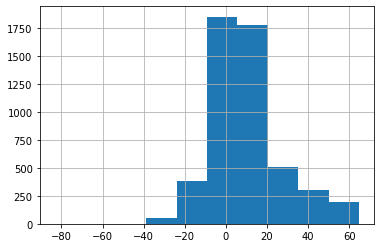

In [142]:
# e_coli_wild_efflux[e_coli_wild_efflux['SMILES'].isin(substrate_transforms.compound_structure_A)].INHIB_AVE_efflux.hist()

# Transfrom compound_A ovelap

In [100]:
comp_a_evader_overlap = evader_transforms[evader_transforms.compound_structure_A.isin(substrate_transforms.compound_structure_A)]

In [128]:
comp_a_evader_overlap

,compound_structure_A,compound_structure_B,idsmiles_A,idsmiles_B,smirks,common_core,measurement_A,measurement_B,measurement_delta,LHS,RHS
60231,Cc1ccc2nc(-c3ccc(/N=C/c4cc(Br)cc(Cl)c4O)cc3)sc2c1,Cc1ccc2nc(-c3ccc(/N=C/c4ccc([N+](=O)[O-])o4)cc...,61152,61165,[*:1]c1cc(Br)cc(Cl)c1O>>[*:1]c1ccc([N+](=O)[O-...,[*:1]/C=N/c1ccc(-c2nc3ccc(C)cc3s2)cc1,-7.70,-0.18,7.52,[*:1]c1cc(Br)cc(Cl)c1O,[*:1]c1ccc([N+](=O)[O-])o1
95075,O=[N+]([O-])c1cc(Cl)cc(/C=N/c2ccc(F)cc2)c1O,O=[N+]([O-])c1ccc(/C=N/c2ccc(F)cc2)o1,61830,62705,[*:1]c1cc(Cl)cc([*:2])c1O>>[*:1]c1ccc([*:2])o1,[*:1]/C=N\c1ccc(F)cc1.[*:2][N+](=O)[O-],-27.95,-2.09,25.86,[*:1]c1cc(Cl)cc([*:2])c1O,[*:1]c1ccc([*:2])o1
108861,CCOc1ccc(/N=C/c2ccc([N+](=O)[O-])s2)cc1,CC(=O)Nc1cccc(/N=C/c2ccc([N+](=O)[O-])s2)c1,62708,62717,[*:1]c1ccc(OCC)cc1>>[*:1]c1cccc(NC(C)=O)c1,[*:1]/N=C/c1ccc([N+](=O)[O-])s1,5.97,-2.18,-8.15,[*:1]c1ccc(OCC)cc1,[*:1]c1cccc(NC(C)=O)c1
108864,Cc1ccc(/N=C/c2ccc([N+](=O)[O-])s2)cc1I,CC(=O)Nc1cccc(/N=C/c2ccc([N+](=O)[O-])s2)c1,62714,62717,[*:1]c1ccc(C)c(I)c1>>[*:1]c1cccc(NC(C)=O)c1,[*:1]/N=C/c1ccc([N+](=O)[O-])s1,-36.24,-2.18,34.06,[*:1]c1ccc(C)c(I)c1,[*:1]c1cccc(NC(C)=O)c1
108866,CC(=O)c1cccc(/N=C/c2ccc([N+](=O)[O-])s2)c1,CC(=O)Nc1cccc(/N=C/c2ccc([N+](=O)[O-])s2)c1,62716,62717,[*:1]c1cccc(C(C)=O)c1>>[*:1]c1cccc(NC(C)=O)c1,[*:1]/N=C/c1ccc([N+](=O)[O-])s1,9.64,-2.18,-11.82,[*:1]c1cccc(C(C)=O)c1,[*:1]c1cccc(NC(C)=O)c1
...,...,...,...,...,...,...,...,...,...,...,...
1404499,CCOC(=O)Cn1ccc(=N)cc1.Cl,Br.CCCCCCCCCCn1ccc(=N)cc1,27928,28236,[*:1]CC(=O)OCC>>[*:1]CCCCCCCCCC,[*:1]n1ccc(=N)cc1,0.26,-5.56,-5.82,[*:1]CC(=O)OCC,[*:1]CCCCCCCCCC
1404506,Br.CCn1ccc(=N)cc1,Br.CCCCCCCCCCn1ccc(=N)cc1,27987,28236,[*:1]CC>>[*:1]CCCCCCCCCC,[*:1]n1ccc(=N)cc1,-6.60,-5.56,1.04,[*:1]CC,[*:1]CCCCCCCCCC
1404512,CCCn1ccc(=N)cc1.I,Br.CCCCCCCCCCn1ccc(=N)cc1,28118,28236,[*:1]CCC>>[*:1]CCCCCCCCCC,[*:1]n1ccc(=N)cc1,1.42,-5.56,-6.98,[*:1]CCC,[*:1]CCCCCCCCCC
1404517,CCCCn1ccc(=N)cc1.I,Br.CCCCCCCCCCn1ccc(=N)cc1,28145,28236,[*:1]CCCC>>[*:1]CCCCCCCCCC,[*:1]n1ccc(=N)cc1,-14.52,-5.56,8.96,[*:1]CCCC,[*:1]CCCCCCCCCC


In [101]:
len(comp_a_evader_overlap.compound_structure_B.unique())

30

In [102]:
comp_a_substrate_overlap = substrate_transforms[substrate_transforms.compound_structure_A.isin(evader_transforms.compound_structure_A)]

In [103]:
len(comp_a_substrate_overlap.compound_structure_B.unique())

71

In [104]:
len(comp_a_evader_overlap.compound_structure_A.unique())

100

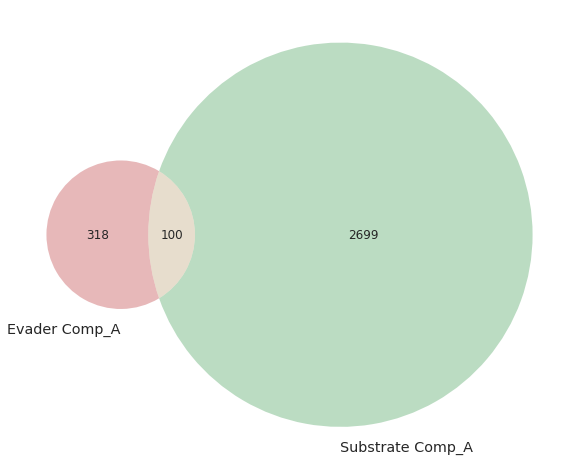

In [105]:
plt.figure(figsize=(10,10))

venn2([set(evader_transforms.compound_structure_A.to_list()), 
      set(substrate_transforms.compound_structure_A.to_list())],
       set_labels=('Evader Comp_A', 'Substrate Comp_A')
     )

## How are overlapping transforms split?

In [106]:
len(comp_a_evader_overlap[comp_a_evader_overlap['compound_structure_A'].isin(evader_transforms.compound_structure_A)])

89

In [61]:
len(comp_a_evader_substrate_overlap.compound_structure_B.unique())

96

In [68]:
len(substrate_transforms[substrate_transforms['compound_structure_B'].isin(comp_a_evader_substrate_overlap.compound_structure_B)].compound_structure_B.unique())

96

In [81]:
len(comp_a_substrate_evader_overlap[comp_a_substrate_evader_overlap['compound_structure_B'].isin(evader_transforms.compound_structure_B)].compound_structure_B.unique())

46

In [73]:
len(evader_transforms[evader_transforms['compound_structure_B'].isin(comp_a_evader_substrate_overlap.compound_structure_B)].compound_structure_B.unique())

0

# TSNE of RHS and LHS of overlap

In [106]:
comp_a_substrate_overlap['mol_b'] = comp_a_substrate_overlap.compound_structure_B.apply(Chem.MolFromSmiles)
comp_a_substrate_overlap['label'] = 'substrate_overlap_B'
comp_a_substrate_overlap = comp_a_substrate_overlap.dropna(subset=['mol_b'])

comp_a_substrate_overlap['fps']=comp_a_substrate_overlap.mol_b.apply(MACCSkeys.GenMACCSKeys)

unique_substrate =  comp_a_substrate_overlap.drop_duplicates(subset=['compound_structure_B'])



/homes/dgurvic/software/miniconda3/envs/jupt_test/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/homes/dgurvic/software/miniconda3/envs/jupt_test/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [107]:
comp_a_evader_overlap['mol_b'] = comp_a_evader_overlap.compound_structure_B.apply(Chem.MolFromSmiles)
comp_a_evader_overlap['label'] = 'evader_overlap_B'
comp_a_evader_overlap = comp_a_evader_overlap.dropna(subset=['mol_b'])

comp_a_evader_overlap['fps']=comp_a_evader_overlap.mol_b.apply(MACCSkeys.GenMACCSKeys)

unique_evader =  comp_a_evader_overlap.drop_duplicates(subset=['compound_structure_B'])


/homes/dgurvic/software/miniconda3/envs/jupt_test/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/homes/dgurvic/software/miniconda3/envs/jupt_test/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [108]:
append = unique_evader.append(unique_substrate).reset_index(drop=True)

In [109]:
append.label.value_counts()

substrate_overlap_B    71
evader_overlap_B       30
Name: label, dtype: int64

In [110]:
len(append)

101

In [115]:
append_tsne =  master_functions.tsne_no_plot(append['fps'], 5)

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 101 samples in 0.001s...
[t-SNE] Computed neighbors for 101 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 101 / 101
[t-SNE] Mean sigma: 0.341923
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.464149
[t-SNE] KL divergence after 1000 iterations: 0.468673


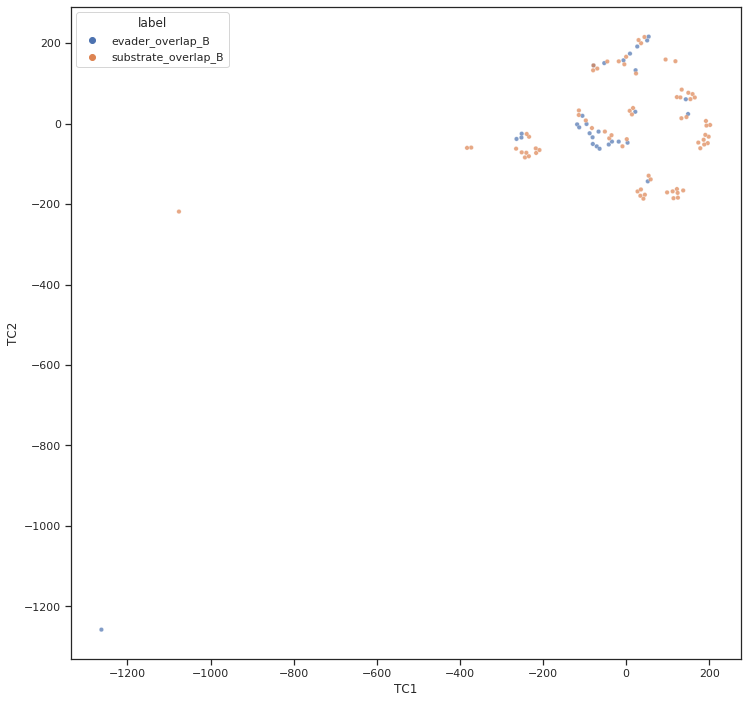

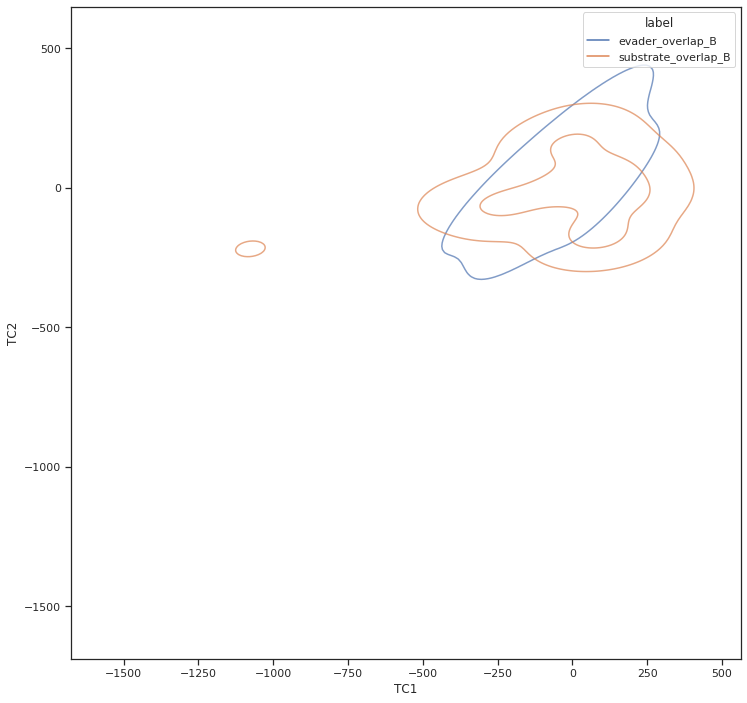

In [116]:
fig, ax = plt.subplots(figsize=(12,12))
sns.scatterplot(x='TC1',y='TC2',data=append_tsne, s=20 ,alpha=0.7, hue=append['label']) 

fig, ax = plt.subplots(figsize=(12,12))

sns.kdeplot(x='TC1',y='TC2',data=append_tsne,alpha=0.7, hue=append['label'], levels = 3)

# Physchem of overlap

/homes/dgurvic/software/miniconda3/envs/jupt_test/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [79]:
unique_evader_transforms = comp_a_evader_overlap.drop_duplicates(subset=['compound_structure_A'])

unique_evader_transforms['Mol_A'] = unique_evader_transforms.compound_structure_A.apply(Chem.MolFromSmiles)
unique_evader_transforms['Mol_B'] = unique_evader_transforms.compound_structure_B.apply(Chem.MolFromSmiles)


unique_evader_transforms_comp_a = comp_a_evader_overlap.drop_duplicates(subset=['compound_structure_A'])[['compound_structure_A']]
unique_evader_transforms_comp_b = comp_a_evader_overlap.drop_duplicates(subset=['compound_structure_A'])[['compound_structure_B']]

/homes/dgurvic/software/miniconda3/envs/jupt_test/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/homes/dgurvic/software/miniconda3/envs/jupt_test/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [80]:
unique_substrate_transforms = comp_a_substrate_overlap.drop_duplicates(subset=['compound_structure_A'])

unique_substrate_transforms['Mol_A'] = unique_substrate_transforms.compound_structure_A.apply(Chem.MolFromSmiles)
unique_substrate_transforms['Mol_B'] = unique_substrate_transforms.compound_structure_B.apply(Chem.MolFromSmiles)

# unique_substrate_transforms_comp_a = comp_a_substrate_overlap.drop_duplicates(subset=['compound_structure_A'])[['compound_structure_A']]

# unique_substrate_transforms_comp_b = comp_a_substrate_overlap.drop_duplicates(subset=['compound_structure_A'])[['compound_structure_B']]

/homes/dgurvic/software/miniconda3/envs/jupt_test/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/homes/dgurvic/software/miniconda3/envs/jupt_test/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [82]:
unique_substrate_transforms_comp_b_feats = master_functions.calc_feats(unique_substrate_transforms.Mol_B)

In [83]:
unique_substrate_transforms_comp_b_feats

,MolWt,LogP,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumHeavyAtoms,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,RingCount,FractionCSP3,TPSA
0,195.174,1.64820,4.0,1.0,5.0,3.0,14.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.111111,72.60
1,195.174,1.64820,4.0,1.0,5.0,3.0,14.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.111111,72.60
2,195.174,1.64820,4.0,1.0,5.0,3.0,14.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.111111,72.60
3,195.174,1.64820,4.0,1.0,5.0,3.0,14.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.111111,72.60
4,195.174,1.64820,4.0,1.0,5.0,3.0,14.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.111111,72.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645,333.100,4.34550,3.0,1.0,9.0,1.0,21.0,0.0,0.0,0.0,1.0,2.0,3.0,3.0,0.083333,54.46
646,320.218,3.55597,2.0,1.0,3.0,6.0,15.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.583333,28.78
647,320.218,3.55597,2.0,1.0,3.0,6.0,15.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.583333,28.78
648,320.218,3.55597,2.0,1.0,3.0,6.0,15.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.583333,28.78


In [19]:
e_coli_wild_efflux_feats = calc_feats(comp_a_evader_overlap)

e_coli_wild_efflux_feats = e_coli_wild_efflux_feats.dropna()



ArgumentError: Python argument types in
    rdkit.Chem.rdMolDescriptors._CalcMolWt(str)
did not match C++ signature:
    _CalcMolWt(RDKit::ROMol mol, bool onlyHeavy=False)

In [85]:
master_functions.clean_mmpa_pairs_len(evader_transforms)

Initial number of transofrms: 2385 
Number fo transforms disqualified based on length discrepancy: 1948 
Remaining number of transforms: 437


,compound_structure_A,compound_structure_B,idsmiles_A,idsmiles_B,smirks,common_core,measurement_A,measurement_B,measurement_delta,LHS,RHS
5578,O/C(=C\C=N\c1ccc(Br)cc1)c1ccc(Br)cc1,O=C(/C=C(\O)c1ccc(Br)cc1)C(F)(F)F,752,1153,[*:1]/C=N\c1ccc(Br)cc1>>[*:1]C(=O)C(F)(F)F,[*:1]/C=C(\O)c1ccc(Br)cc1,15.84,30.93,15.09,[*:1]/C=N\c1ccc(Br)cc1,[*:1]C(=O)C(F)(F)F
5581,Cc1ccc(/N=C/C=C(\O)c2ccc(Br)cc2)cc1,O=C(/C=C(\O)c1ccc(Br)cc1)C(F)(F)F,753,1153,[*:1]/C=N\c1ccc(C)cc1>>[*:1]C(=O)C(F)(F)F,[*:1]/C=C(\O)c1ccc(Br)cc1,-1.73,30.93,32.66,[*:1]/C=N\c1ccc(C)cc1,[*:1]C(=O)C(F)(F)F
5583,O/C(=C\C=N\c1cccc(Cl)c1)c1ccc(Br)cc1,O=C(/C=C(\O)c1ccc(Br)cc1)C(F)(F)F,755,1153,[*:1]/C=N\c1cccc(Cl)c1>>[*:1]C(=O)C(F)(F)F,[*:1]/C=C(\O)c1ccc(Br)cc1,-21.10,30.93,52.03,[*:1]/C=N\c1cccc(Cl)c1,[*:1]C(=O)C(F)(F)F
13581,COc1ccc(/C=C2\C(=O)NC(=O)N(c3ccc(C)cc3)C2=O)cc1,Cc1ccc(N2C(=O)NC(=O)/C(=C\c3ccc([N+](=O)[O-])o...,31110,31119,[*:1]c1ccc(OC)cc1>>[*:1]c1ccc([N+](=O)[O-])o1,[*:1]/C=C1\C(=O)NC(=O)N(c2ccc(C)cc2)C1=O,-2.80,-6.37,-3.57,[*:1]c1ccc(OC)cc1,[*:1]c1ccc([N+](=O)[O-])o1
13602,COc1cc(/C=C2\C(=O)NC(=O)N(c3ccc(C)cc3)C2=O)cc(...,Cc1ccc(N2C(=O)NC(=O)/C(=C\c3ccc([N+](=O)[O-])o...,31112,31119,[*:1]c1cc(I)c(O)c(OC)c1>>[*:1]c1ccc([N+](=O)[O...,[*:1]/C=C1\C(=O)NC(=O)N(c2ccc(C)cc2)C1=O,8.95,-6.37,-15.32,[*:1]c1cc(I)c(O)c(OC)c1,[*:1]c1ccc([N+](=O)[O-])o1
...,...,...,...,...,...,...,...,...,...,...,...
1404506,Br.CCn1ccc(=N)cc1,Br.CCCCCCCCCCn1ccc(=N)cc1,27987,28236,[*:1]CC>>[*:1]CCCCCCCCCC,[*:1]n1ccc(=N)cc1,-6.60,-5.56,1.04,[*:1]CC,[*:1]CCCCCCCCCC
1404512,CCCn1ccc(=N)cc1.I,Br.CCCCCCCCCCn1ccc(=N)cc1,28118,28236,[*:1]CCC>>[*:1]CCCCCCCCCC,[*:1]n1ccc(=N)cc1,1.42,-5.56,-6.98,[*:1]CCC,[*:1]CCCCCCCCCC
1404517,CCCCn1ccc(=N)cc1.I,Br.CCCCCCCCCCn1ccc(=N)cc1,28145,28236,[*:1]CCCC>>[*:1]CCCCCCCCCC,[*:1]n1ccc(=N)cc1,-14.52,-5.56,8.96,[*:1]CCCC,[*:1]CCCCCCCCCC
1404521,Br.CCCCCCn1ccc(=N)cc1,Br.CCCCCCCCCCn1ccc(=N)cc1,28228,28236,[*:1]CCCCCC>>[*:1]CCCCCCCCCC,[*:1]n1ccc(=N)cc1,13.72,-5.56,-19.28,[*:1]CCCCCC,[*:1]CCCCCCCCCC


In [86]:
master_functions.clean_mmpa_pairs_len(substrate_transforms)

Initial number of transofrms: 14668 
Number fo transforms disqualified based on length discrepancy: 4150 
Remaining number of transforms: 10518


,compound_structure_A,compound_structure_B,idsmiles_A,idsmiles_B,smirks,common_core,measurement_A,measurement_B,measurement_delta,LHS,RHS
329,C/C(=N\NC(=O)c1nnn(-c2nonc2N)c1-c1ccccc1)c1ccc...,Nc1nonc1-n1nnc(C(=O)N/N=C/c2ccccc2O)c1-c1ccccc1,69387,69423,[*:1]C>>[*:1][H],[*:1]/C(=N\NC(=O)c1nnn(-c2nonc2N)c1-c1ccccc1)c...,8.85,55.86,47.01,[*:1]C,[*:1][H]
2191,C/C(=N\Nc1nc(Nc2cccc(Br)c2)nc(N2CCOCC2)n1)c1cc...,C/C(=N\Nc1nc(Nc2cccc(Br)c2)nc(N2CCOCC2)n1)c1cc...,54132,54133,[*:1]c1ccc(Cl)cc1>>[*:1]c1ccc(N)cc1,[*:1]/C(C)=N/Nc1nc(Nc2cccc(Br)c2)nc(N2CCOCC2)n1,-0.44,63.09,63.53,[*:1]c1ccc(Cl)cc1,[*:1]c1ccc(N)cc1
2258,C/C(=N/Nc1nc(Nc2cccc(Br)c2)nc(N2CCOCC2)n1)c1cc...,C/C(=N/Nc1nc(Nc2cccc(Br)c2)nc(N2CCOCC2)n1)c1cc...,54138,54140,[*:1]c1ccc(Br)cc1>>[*:1]c1ccccc1,[*:1]/C(C)=N\Nc1nc(Nc2cccc(Br)c2)nc(N2CCOCC2)n1,14.87,66.49,51.62,[*:1]c1ccc(Br)cc1,[*:1]c1ccccc1
2259,C/C(=N/Nc1nc(Nc2cccc(Br)c2)nc(N2CCOCC2)n1)c1cc...,C/C(=N/Nc1nc(Nc2cccc(Br)c2)nc(N2CCOCC2)n1)c1cc...,54139,54140,[*:1]c1ccc(F)cc1>>[*:1]c1ccccc1,[*:1]/C(C)=N\Nc1nc(Nc2cccc(Br)c2)nc(N2CCOCC2)n1,47.29,66.49,19.20,[*:1]c1ccc(F)cc1,[*:1]c1ccccc1
2723,Cc1ccc2[nH]c(/C(C#N)=C/c3c(Cl)cccc3Cl)nc2c1,Cc1ccc2[nH]c(/C(C#N)=C/c3cc(Br)c(O)c(Br)c3)nc2c1,58348,58331,[*:1]c1c(Cl)cccc1Cl>>[*:1]c1cc(Br)c(O)c(Br)c1,[*:1]/C=C(\C#N)c1nc2cc(C)ccc2[nH]1,3.82,62.41,58.59,[*:1]c1c(Cl)cccc1Cl,[*:1]c1cc(Br)c(O)c(Br)c1
...,...,...,...,...,...,...,...,...,...,...,...
1405589,Cc1ccccc1NCn1nc(-c2ccc(Cl)cc2Cl)oc1=S,OCn1nc(-c2ccc(Cl)cc2Cl)oc1=S,28917,13687,[*:1]CNc1ccccc1C>>[*:1]CO,[*:1]n1nc(-c2ccc(Cl)cc2Cl)oc1=S,46.66,61.85,15.19,[*:1]CNc1ccccc1C,[*:1]CO
1406560,O=[N+]([O-])c1ccc(-n2ncc3c([N+](=O)[O-])cc([N+...,O=[N+]([O-])c1cc([N+](=O)[O-])c2cn[nH]c2c1,63724,62159,[*:1]c1ccc([N+](=O)[O-])cc1>>[*:1][H],[*:1]n1ncc2c([N+](=O)[O-])cc([N+](=O)[O-])cc21,-19.26,80.56,99.82,[*:1]c1ccc([N+](=O)[O-])cc1,[*:1][H]
1406563,Cc1ccc(-n2ncc3c([N+](=O)[O-])cc([N+](=O)[O-])c...,O=[N+]([O-])c1cc([N+](=O)[O-])c2cn[nH]c2c1,63726,62159,[*:1]c1ccc(C)cc1>>[*:1][H],[*:1]n1ncc2c([N+](=O)[O-])cc([N+](=O)[O-])cc21,-14.22,80.56,94.78,[*:1]c1ccc(C)cc1,[*:1][H]
1406565,O=C(O)c1ccccc1-n1ncc2c([N+](=O)[O-])cc([N+](=O...,O=[N+]([O-])c1cc([N+](=O)[O-])c2cn[nH]c2c1,70401,62159,[*:1]c1ccccc1C(=O)O>>[*:1][H],[*:1]n1ncc2c([N+](=O)[O-])cc([N+](=O)[O-])cc21,-8.49,80.56,89.05,[*:1]c1ccccc1C(=O)O,[*:1][H]


In [15]:
a, b, c = master_functions.calculate_fractions_mk4(comp_a_evader_overlap)


  0%|          | 8/1609 [00:00<00:20, 79.63it/s]

Generating molecular objects from pre-defined substructures
Calcualting LHS+RHS matches


100%|██████████| 1609/1609 [00:09<00:00, 173.84it/s]


In [14]:
features_all_evade, l_feats_evade, r_feats_evade = master_functions.calculate_fractions_mk4(evader_transforms)


  0%|          | 1/2385 [00:00<06:05,  6.53it/s]

Generating molecular objects from pre-defined substructures
Calcualting LHS+RHS matches


100%|██████████| 2385/2385 [00:12<00:00, 183.98it/s]


In [13]:
features_all_neg, l_feats_neg, r_feats_neg = master_functions.calculate_fractions_mk4(mmpa_zero_neg)

features_all_pos, l_feats_pos, r_feats_pos = master_functions.calculate_fractions_mk4(mmpa_zero_pos)

,compound_structure_A,compound_structure_B,idsmiles_A,idsmiles_B,smirks,common_core,measurement_A,measurement_B,measurement_delta,LHS,RHS
5578,O/C(=C\C=N\c1ccc(Br)cc1)c1ccc(Br)cc1,O=C(/C=C(\O)c1ccc(Br)cc1)C(F)(F)F,752,1153,[*:1]/C=N\c1ccc(Br)cc1>>[*:1]C(=O)C(F)(F)F,[*:1]/C=C(\O)c1ccc(Br)cc1,15.84,30.93,15.09,[*:1]/C=N\c1ccc(Br)cc1,[*:1]C(=O)C(F)(F)F
5581,Cc1ccc(/N=C/C=C(\O)c2ccc(Br)cc2)cc1,O=C(/C=C(\O)c1ccc(Br)cc1)C(F)(F)F,753,1153,[*:1]/C=N\c1ccc(C)cc1>>[*:1]C(=O)C(F)(F)F,[*:1]/C=C(\O)c1ccc(Br)cc1,-1.73,30.93,32.66,[*:1]/C=N\c1ccc(C)cc1,[*:1]C(=O)C(F)(F)F
5583,O/C(=C\C=N\c1cccc(Cl)c1)c1ccc(Br)cc1,O=C(/C=C(\O)c1ccc(Br)cc1)C(F)(F)F,755,1153,[*:1]/C=N\c1cccc(Cl)c1>>[*:1]C(=O)C(F)(F)F,[*:1]/C=C(\O)c1ccc(Br)cc1,-21.10,30.93,52.03,[*:1]/C=N\c1cccc(Cl)c1,[*:1]C(=O)C(F)(F)F
5584,COc1ccccc1/N=C/C=C(\O)c1ccc(Br)cc1,O=C(/C=C(\O)c1ccc(Br)cc1)C(F)(F)F,756,1153,[*:1]/C=N\c1ccccc1OC>>[*:1]C(=O)C(F)(F)F,[*:1]/C=C(\O)c1ccc(Br)cc1,6.04,30.93,24.89,[*:1]/C=N\c1ccccc1OC,[*:1]C(=O)C(F)(F)F
5998,CN(/C=C/[N+](=O)[O-])c1ccccc1,O=[N+]([O-])/C=C/c1ccc(Cl)cc1Cl,43517,43527,[*:1]N(C)c1ccccc1>>[*:1]c1ccc(Cl)cc1Cl,[*:1]/C=C/[N+](=O)[O-],0.93,-0.05,-0.98,[*:1]N(C)c1ccccc1,[*:1]c1ccc(Cl)cc1Cl
...,...,...,...,...,...,...,...,...,...,...,...
1404506,Br.CCn1ccc(=N)cc1,Br.CCCCCCCCCCn1ccc(=N)cc1,27987,28236,[*:1]CC>>[*:1]CCCCCCCCCC,[*:1]n1ccc(=N)cc1,-6.60,-5.56,1.04,[*:1]CC,[*:1]CCCCCCCCCC
1404512,CCCn1ccc(=N)cc1.I,Br.CCCCCCCCCCn1ccc(=N)cc1,28118,28236,[*:1]CCC>>[*:1]CCCCCCCCCC,[*:1]n1ccc(=N)cc1,1.42,-5.56,-6.98,[*:1]CCC,[*:1]CCCCCCCCCC
1404517,CCCCn1ccc(=N)cc1.I,Br.CCCCCCCCCCn1ccc(=N)cc1,28145,28236,[*:1]CCCC>>[*:1]CCCCCCCCCC,[*:1]n1ccc(=N)cc1,-14.52,-5.56,8.96,[*:1]CCCC,[*:1]CCCCCCCCCC
1404521,Br.CCCCCCn1ccc(=N)cc1,Br.CCCCCCCCCCn1ccc(=N)cc1,28228,28236,[*:1]CCCCCC>>[*:1]CCCCCCCCCC,[*:1]n1ccc(=N)cc1,13.72,-5.56,-19.28,[*:1]CCCCCC,[*:1]CCCCCCCCCC


In [ ]:
sub_and_evade_features = calc_feats(sub_and_evade['Mol'])
sub_and_evade_features['label'] = sub_and_evade['label']

# DEV

In [71]:
evader_transforms.compound_structure_A.iloc[0] # compound from evader transform that should be INACTIVE in wild

'O/C(=C\\C=N\\c1ccc(Br)cc1)c1ccc(Br)cc1'

In [74]:
e_coli_wild_efflux['SMILES'].apply(Chem.CanonSmiles)

0                                     C1B2CC3CC1CC(C2)C3.N
1                   C1B2CC3CC1CC(C2)C3.c1ccc(Cc2ccncc2)cc1
2                        Brc1cncc(Br)c1.C1B2CC3CC1CC(C2)C3
3                   C1B2CC3CC1CC(C2)C3.c1ccc(Cc2cccnc2)cc1
4                         C1B2CC3CC1CC(C2)C3.CN(C)c1ccncc1
                               ...                        
73732                               Cl.c1csc(CNCc2cccs2)c1
73733                                Clc1ccc(NCc2cccs2)cc1
73734                            O=[As](O)(c1cccs1)c1cccs1
73735    COc1cc([C@@H]2c3cc4c(cc3[C@@H](OC3OC5CO[C@@H](...
73736                               O=C(O)C=CC(=O)Nc1nccs1
Name: SMILES, Length: 73737, dtype: object

In [110]:
e_coli_wild_efflux[e_coli_wild_efflux['SMILES'] == evader_transforms.compound_structure_A.iloc[0] ]

,SMILES,INHIB_AVE_wild,INHIB_AVE_efflux,Mol,fps,abs_diff,sub_class
751,O/C(=C\C=N\c1ccc(Br)cc1)c1ccc(Br)cc1,-16.91,-1.07,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",15.84,increase


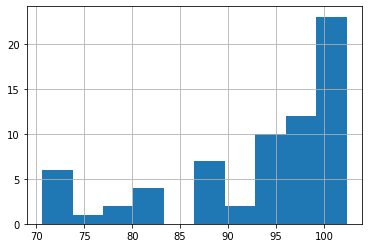

In [118]:
e_coli_wild_efflux[e_coli_wild_efflux['SMILES'].isin(evader_transforms.compound_structure_B)].INHIB_AVE_wild.hist()

In [ ]:
matches_for_evaders = []
for smile in range(len(efflux_evader)):
    matches_for_evaders.append(len(ecoli_wild_index[ecoli_wild_index['compound_structure_B'] == efflux_evader.SMILES.iloc[smile]]))

In [110]:
comp_a_evader_overlap.compound_structure_A.iloc[0]

'Cc1ccc2nc(-c3ccc(/N=C/c4cc(Br)cc(Cl)c4O)cc3)sc2c1'

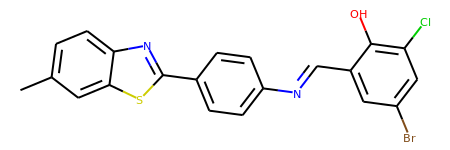

In [146]:
comp  = comp_a_evader_overlap.compound_structure_A.iloc[0]

Chem.MolFromSmiles(comp_a_evader_overlap[comp_a_evader_overlap['compound_structure_A'] == comp].iloc[0].compound_structure_A)

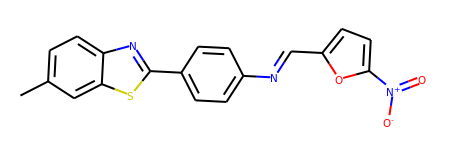

In [139]:
# evader: 

Chem.MolFromSmiles(comp_a_evader_overlap[comp_a_evader_overlap['compound_structure_A'] == comp].iloc[0].compound_structure_B)

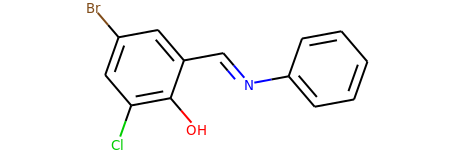

In [143]:
Chem.MolFromSmiles(comp_a_substrate_overlap[comp_a_substrate_overlap['compound_structure_A'] == comp].iloc[0].compound_structure_B)

In [115]:
comp_a_substrate_overlap

array(['O=C(CNc1ccc(Cl)cc1)N/N=C/c1ccc(Cl)cc1',
       'O=C(CSCc1ccc(Cl)cc1)N/N=C/c1ccc(Cl)cc1',
       'O=[N+]([O-])c1ccc(/N=C/c2cc(Cl)cc(Cl)c2O)cc1',
       'O=[N+]([O-])c1cc(Cl)cc(/C=N/c2ccc(F)cc2)c1O',
       'CCOc1ccc(/N=C/c2ccc([N+](=O)[O-])s2)cc1',
       'Cc1ccc(/N=C/c2ccc([N+](=O)[O-])s2)cc1I',
       'CC(=O)c1cccc(/N=C/c2ccc([N+](=O)[O-])s2)c1',
       'COc1cc(Br)cc(Br)c1OCC(=O)N/N=C/c1ccc([N+](=O)[O-])o1',
       'CC1(C)SC2C(NC(=O)Cc3ccccc3)C(=O)N2C1C(=O)[O-].[K+]',
       'O=C(CCl)NCCc1ccccc1', 'CC(Oc1ccccc1)C(=O)Nc1nc(-c2ccccn2)cs1',
       'COc1cc(C(=O)Nc2nccs2)cc(OC)c1OC',
       'C/C(=N/Nc1ccccc1[N+](=O)[O-])c1ccccc1',
       'CN(C)c1c([N+](=O)[O-])ncn1C', 'O=C(CSc1ccccn1)N/N=C/C=C/c1ccccc1',
       'CCn1cc(C(=O)O)c(=O)c2cnc(N3CCN(C(=S)Nc4cc(OC)ccc4OC)CC3)nc21',
       'Cc1cccc(O)c1/N=C/c1ccc([N+](=O)[O-])cc1',
       'O=[N+]([O-])c1ccc(/C=N/c2cc(Cl)ccc2O)cc1',
       'O=C(N/N=C/c1ccc([N+](=O)[O-])o1)c1cccc([N+](=O)[O-])c1',
       'Cc1n[n+]2c(C(=O)N3CCN(C)CC3)c(C)[n-]n

In [117]:
lhs_and_comp_a_evader = comp_a_evader_overlap[(comp_a_evader_overlap['LHS'].isin(comp_a_substrate_overlap['LHS'].values)) & (comp_a_evader_overlap['compound_structure_A'].isin(comp_a_substrate_overlap['compound_structure_A'].values))]

In [118]:
lhs_and_comp_a_substrate = comp_a_substrate_overlap[comp_a_substrate_overlap['LHS'].isin(comp_a_evader_overlap['LHS'].values) & (comp_a_substrate_overlap['compound_structure_A'].isin(comp_a_evader_overlap['compound_structure_A'].values))]

In [119]:
len(lhs_and_comp_a_evader)

120

In [120]:
len(lhs_and_comp_a_substrate)

211

In [69]:
lhs_and_comp_a_evader.iloc[500]


compound_structure_A           C[N+](C)(C)CC(F)([N+](=O)[O-])[N+](=O)[O-]
compound_structure_B                     O=[N+]([O-])c1cccc2c1no[n+]2[O-]
idsmiles_A                                                          12141
idsmiles_B                                                          64571
smirks                  [*:1]C(F)(C[N+](C)(C)C)[N+](=O)[O-]>>[*:1]c1cc...
common_core                                             [*:1][N+](=O)[O-]
measurement_A                                                        1.21
measurement_B                                                      -15.28
measurement_delta                                                  -16.49
LHS                                   [*:1]C(F)(C[N+](C)(C)C)[N+](=O)[O-]
RHS                                             [*:1]c1cccc2c1no[n+]2[O-]
Name: 1035589, dtype: object

In [166]:
com = lhs_and_comp_a_evader.compound_structure_A.iloc[0]
lh = lhs_and_comp_a_evader.LHS.iloc[0]

evader_example =  lhs_and_comp_a_evader[(lhs_and_comp_a_evader['compound_structure_A'] == com) & (lhs_and_comp_a_evader['LHS'] == lh)]

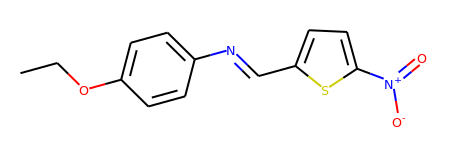

In [167]:
Chem.MolFromSmiles(evader_example.compound_structure_A.iloc[0])

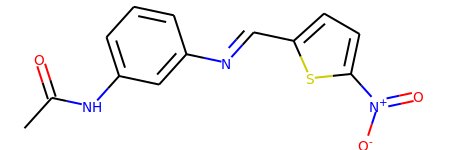

In [168]:
Chem.MolFromSmiles(evader_example.compound_structure_B.iloc[0])

In [169]:
substrate_example =  lhs_and_comp_a_substrate[(lhs_and_comp_a_substrate['compound_structure_A'] == com) & (lhs_and_comp_a_substrate['LHS'] == lh)]

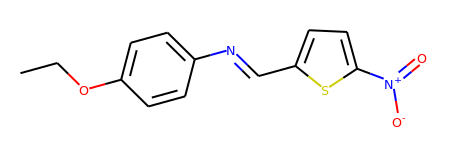

In [173]:
Chem.MolFromSmiles(substrate_example.compound_structure_A.iloc[0])

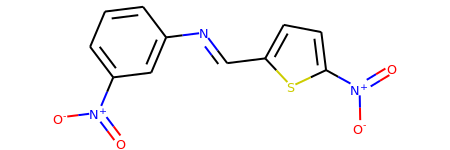

In [174]:
Chem.MolFromSmiles(substrate_example.compound_structure_B.iloc[0])